In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from scipy import stats



In [2]:
# Loading Dataset
DATA_FN = "US_Accidents_March23.parquet"  # Using Parquet file instead of CSV
RANDOM_STATE = 42
TEST_SIZE = 0.2
N_JOBS = -1
RANDOM_SEARCH_ITER = 30
CV_FOLDS = 5

print("Loading dataset...")
df = pd.read_parquet(DATA_FN, engine='pyarrow')
print("Rows:", len(df), "Columns:", len(df.columns))
print("Columns preview:", df.columns.tolist())

#
print("\nSeverity distribution:")
print(df['Severity'].value_counts().sort_index())

# Show missing top
missing = df.isnull().mean().sort_values(ascending=False)
print("\nTop 20 missing rates:")
print(missing.head(20))


# Keep only rows with a valid Severity (1,2,3,4)
df = df[df['Severity'].isin([1,2,3,4])].copy()
df['Severity'] = df['Severity'].astype(int)



Loading dataset...
Rows: 7728394 Columns: 46
Columns preview: ['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

Severity distribution:
Severity
1      67366
2    6156981
3    1299337
4     204710
Name: count, dtype: int64

Top 20 missing rates:
End_Lat                  0.440294
End_Lng                  0.440294
Precipitation(in)        0.285129
Wind_Chill(F)            0.258659
Wind_Speed(mph)   

In [3]:
drop_cols = [
    'ID', 'Source', 'Description', 'End_Time', 'Civil_Twilight',
    'Nautical_Twilight', 'Astronomical_Twilight', 'Number', 'Zipcode',
    'Airport_Code', 'Country', 'Weather_Timestamp'
]

df = df.drop(columns=[c for c in drop_cols if c in df.columns])

df.to_parquet('reduced_cols.parquet')

In [3]:

df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

# Get earliest and latest timestamps
first_date = df['Start_Time'].min()
last_date = df['Start_Time'].max()

print("Earliest record:", first_date)
print("Latest record:", last_date)

# Extract month and year of first record
print("First data period:", first_date.strftime("%B %Y"))
print("Last data period:", last_date.strftime("%B %Y"))


Earliest record: 2016-01-14 20:18:33
Latest record: 2023-03-31 23:30:00
First data period: January 2016
Last data period: March 2023


In [5]:
OUTPUT_DIR = "eda_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
PLOT = True

In [6]:

# Convert all boolean-like columns to proper bool dtype
bool_cols = [
    "Amenity","Bump","Crossing","Give_Way","Junction","No_Exit","Railway",
    "Roundabout","Station","Stop","Traffic_Calming","Traffic_Signal","Turning_Loop"
]
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype(bool)

# Handle datetime columns
for c in ["Start_Time", "End_Time", "Weather_Timestamp"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')

# Fill missing numeric columns with median
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill missing categorical columns with 'Unknown'
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    df[col] = df[col].fillna('Unknown')

# Fill missing datetime values with Start_Time median
for c in ["End_Time", "Weather_Timestamp"]:
    if c in df.columns:
        df[c] = df[c].fillna(df["Start_Time"].median())

# Drop duplicates
df = df.drop_duplicates(subset=["ID"], keep="first")
gc.collect()

print("✅ Cleaning complete.")
print(f"Dataset shape after cleaning: {df.shape}")

# ===================== MISSINGNESS ANALYSIS =====================
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
missing_pct.to_csv(os.path.join(OUTPUT_DIR, "missingness_percent.csv"))
print("\nTop missing columns:\n", missing_pct.head(15))



✅ Cleaning complete.
Dataset shape after cleaning: (7728394, 46)

Top missing columns:
 Start_Time           9.616047
ID                   0.000000
Railway              0.000000
Wind_Speed(mph)      0.000000
Precipitation(in)    0.000000
Weather_Condition    0.000000
Amenity              0.000000
Bump                 0.000000
Crossing             0.000000
Give_Way             0.000000
Junction             0.000000
No_Exit              0.000000
Roundabout           0.000000
Visibility(mi)       0.000000
Station              0.000000
dtype: float64


In [7]:
# ===================== BASIC SUMMARIES =====================
print("\n--- Numerical Summary ---")
num_summary = df[num_cols].describe().T
num_summary.to_csv(os.path.join(OUTPUT_DIR, "numeric_summary.csv"))
print(num_summary.head())

print("\n--- Categorical Summary ---")
cat_summary = df[cat_cols].nunique().sort_values(ascending=False)
cat_summary.to_csv(os.path.join(OUTPUT_DIR, "categorical_unique_counts.csv"))
print(cat_summary.head(15))





--- Numerical Summary ---
               count       mean        std         min         25%        50%  \
Severity   7728394.0   2.212384   0.487531    1.000000    2.000000   2.000000   
Start_Lat  7728394.0  36.201195   5.076079   24.554800   33.399631  35.823974   
Start_Lng  7728394.0 -94.702545  17.391756 -124.623833 -117.219396 -87.766616   
End_Lat    7728394.0  36.227339   3.945038   24.566013   35.186481  36.183495   
End_Lng    7728394.0 -92.336331  14.075809 -124.545748  -93.323463 -88.027890   

                 75%        max  
Severity    2.000000   4.000000  
Start_Lat  40.084959  49.002201  
Start_Lng -80.353676 -67.113167  
End_Lat    37.517262  49.075000  
End_Lng   -84.990476 -67.109242  

--- Categorical Summary ---
ID                       7728394
Description              3761578
Zipcode                   825095
Street                    336307
City                       13679
Airport_Code                2046
County                      1871
Weather_Condition     

In [9]:
# ===================== CORRELATION ANALYSIS =====================
corr = df[num_cols].corr(method='pearson')
corr.to_csv(os.path.join(OUTPUT_DIR, "correlations.csv"))
if PLOT:
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.title("Numeric Correlation Heatmap")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "numeric_correlation_heatmap.png"))
    plt.close()


In [12]:
df.dtypes.value_counts()


object            17
bool              13
float64           12
datetime64[ns]     3
int32              1
Name: count, dtype: int64

In [13]:
bool_cols = df.select_dtypes(include=["bool"]).columns.tolist()
print("Boolean columns:", bool_cols)


Boolean columns: ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']


In [15]:
[col for col in df.columns if "state" in c.lower()]


[]

In [16]:
df[bool_cols].sum().sort_values(ascending=False)


Traffic_Signal     1143772
Crossing            873763
Junction            571342
Stop                214371
Station             201901
Amenity              96334
Railway              66979
Give_Way             36582
No_Exit              19545
Traffic_Calming       7598
Bump                  3514
Roundabout             249
Turning_Loop             0
dtype: int64

In [18]:
# Check first few column names
print(df.columns.tolist())

# Or look for columns with geographic meaning
[col for col in df.columns if "state" in col.lower()]



['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


['State']


Generating boolean %True/%False plots by State...
✓ Saved: eda_outputs\bool_state_Amenity.csv
✓ Saved: eda_outputs\bool_state_Bump.csv
✓ Saved: eda_outputs\bool_state_Crossing.csv
✓ Saved: eda_outputs\bool_state_Give_Way.csv
✓ Saved: eda_outputs\bool_state_Junction.csv
✓ Saved: eda_outputs\bool_state_No_Exit.csv
✓ Saved: eda_outputs\bool_state_Railway.csv
✓ Saved: eda_outputs\bool_state_Roundabout.csv
✓ Saved: eda_outputs\bool_state_Station.csv
✓ Saved: eda_outputs\bool_state_Stop.csv
✓ Saved: eda_outputs\bool_state_Traffic_Calming.csv
✓ Saved: eda_outputs\bool_state_Traffic_Signal.csv
✓ Saved: eda_outputs\bool_state_Turning_Loop.csv

Generating overall %True/%False chart across all data...


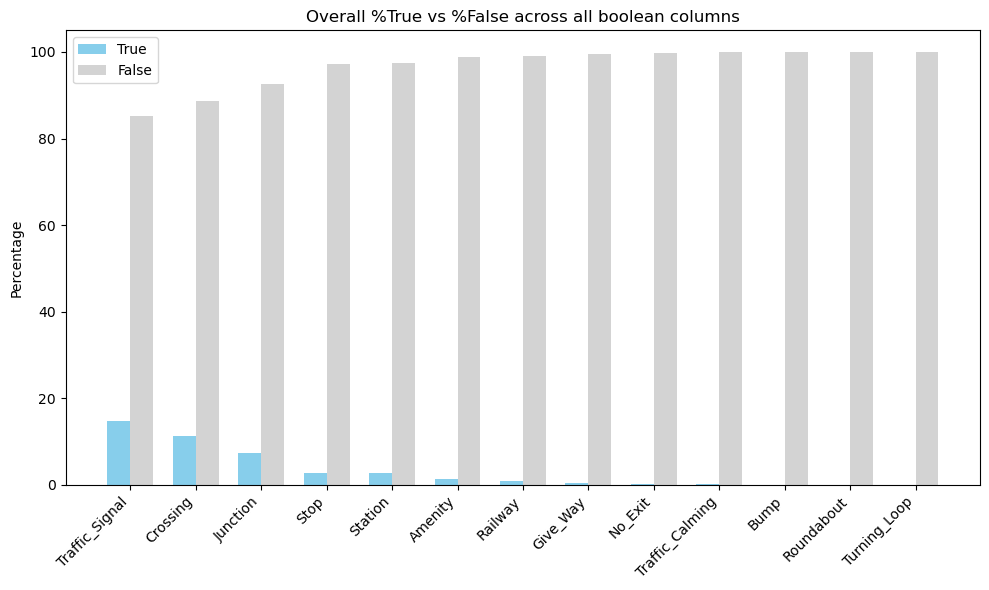

✅ All plots and CSVs generated successfully.


In [20]:
# BOOLEAN DISTRIBUTION BY STATE
print("\nGenerating boolean %True/%False plots by State...")

for col in bool_cols:
    # Compute %True and %False per state
    pct_true = df.groupby(state_col)[col].mean() * 100
    pct_false = 100 - pct_true

    state_df = pd.DataFrame({
        "State": pct_true.index,
        "True_%": pct_true.values,
        "False_%": pct_false.values
    }).sort_values("True_%", ascending=False)

    # Save CSV
    csv_path = os.path.join(OUTPUT_DIR, f"bool_state_{col}.csv")
    state_df.to_csv(csv_path, index=False)

    # Plot chart for each column
    if PLOT:
        plt.figure(figsize=(10, 6))
        sns.barplot(x="True_%", y="State", data=state_df, color='skyblue', label="True")
        sns.barplot(x="False_%", y="State", data=state_df, color='lightgray', label="False", left=state_df["True_%"])
        plt.title(f"% of True vs False for '{col}' by State")
        plt.xlabel("Percentage")
        plt.ylabel("State")
        plt.legend()
        plt.tight_layout()

        fig_path = os.path.join(OUTPUT_DIR, f"bool_state_{col}.png")
        plt.savefig(fig_path, bbox_inches="tight")
        plt.close()

    print(f"✓ Saved: {csv_path}")

# ==================================================
#   TOTAL-LEVEL TRUE vs FALSE BAR CHART
# ==================================================

print("\nGenerating overall %True/%False chart across all data...")

total_summary = []
for col in bool_cols:
    true_pct = df[col].mean() * 100
    false_pct = 100 - true_pct
    total_summary.append({"Column": col, "True_%": true_pct, "False_%": false_pct})

total_df = pd.DataFrame(total_summary).sort_values("True_%", ascending=False)
total_df.to_csv(os.path.join(OUTPUT_DIR, "bool_total_summary.csv"), index=False)

# Plot overall comparison
if PLOT:
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    x = range(len(total_df))

    plt.bar(x, total_df["True_%"], width=bar_width, color="skyblue", label="True")
    plt.bar(
        [i + bar_width for i in x],
        total_df["False_%"],
        width=bar_width,
        color="lightgray",
        label="False"
    )

    plt.xticks([i + bar_width/2 for i in x], total_df["Column"], rotation=45, ha="right")
    plt.ylabel("Percentage")
    plt.title("Overall %True vs %False across all boolean columns")
    plt.legend()
    plt.tight_layout()

    plt.savefig(os.path.join(OUTPUT_DIR, "bool_total_summary.png"), bbox_inches="tight")
    plt.show()

print("✅ All plots and CSVs generated successfully.")

Boolean columns: ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

Generating boolean %True/%False plots by State...

Top states for Amenity:
   State     True_%    False_%
6     DC  10.606549  89.393451
45    WA   6.917327  93.082673
17    MA   4.169624  95.830376
32    NY   2.997184  97.002816
41    TX   1.861069  98.138931


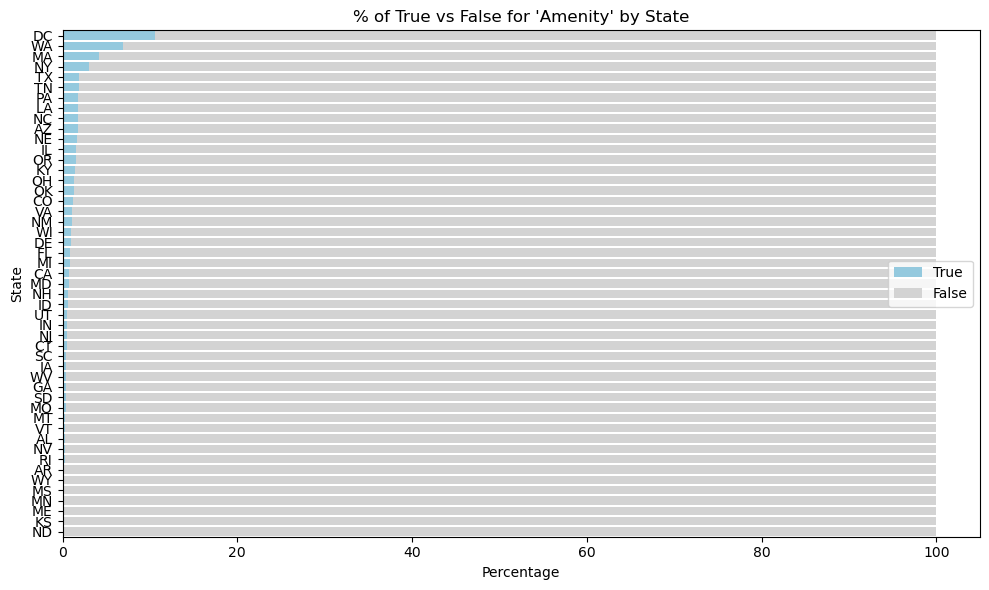


Top states for Bump:
   State    True_%    False_%
2     AZ  0.424362  99.575638
34    OK  0.168566  99.831434
4     CO  0.130935  99.869065
35    OR  0.118557  99.881443
45    WA  0.107188  99.892812


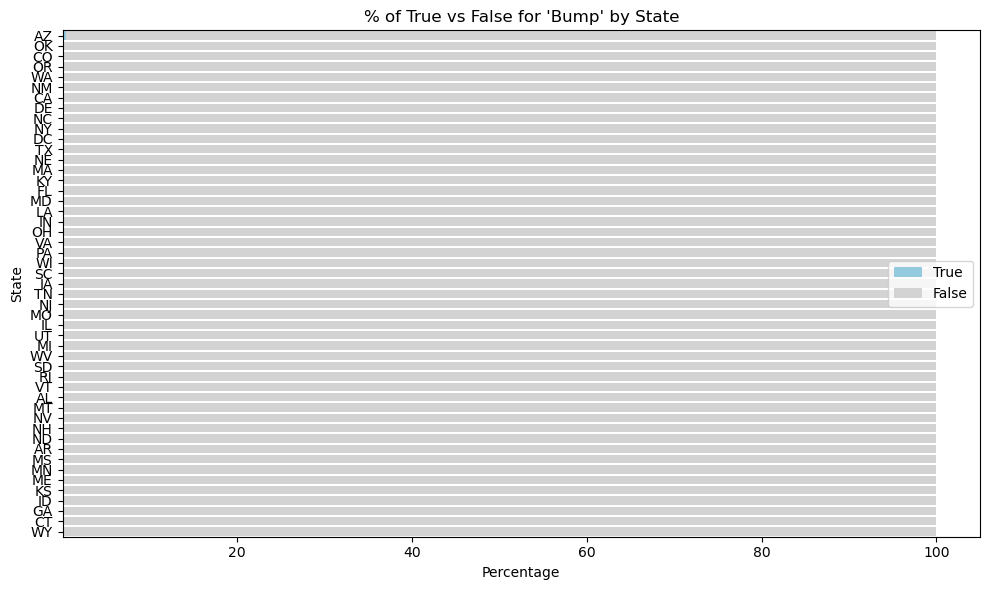


Top states for Crossing:
   State     True_%    False_%
34    OK  35.763387  64.236613
2     AZ  33.029324  66.970676
27    NE  27.658469  72.341531
6     DC  23.617821  76.382179
11    ID  23.567159  76.432841


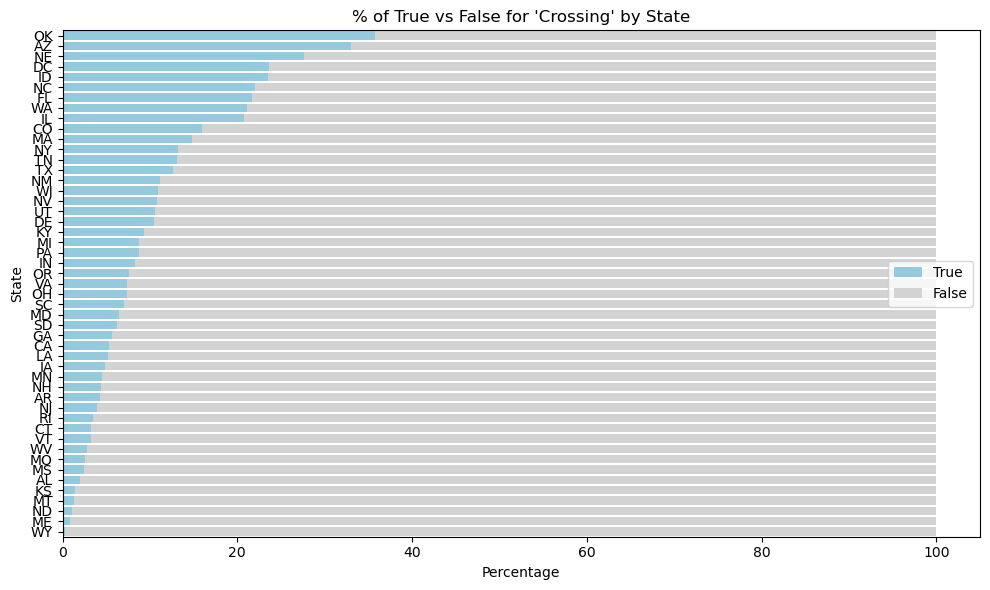


Top states for Give_Way:
   State    True_%    False_%
37    RI  4.460550  95.539450
23    MS  2.522890  97.477110
0     AL  1.834844  98.165156
36    PA  1.531589  98.468411
19    ME  1.334322  98.665678


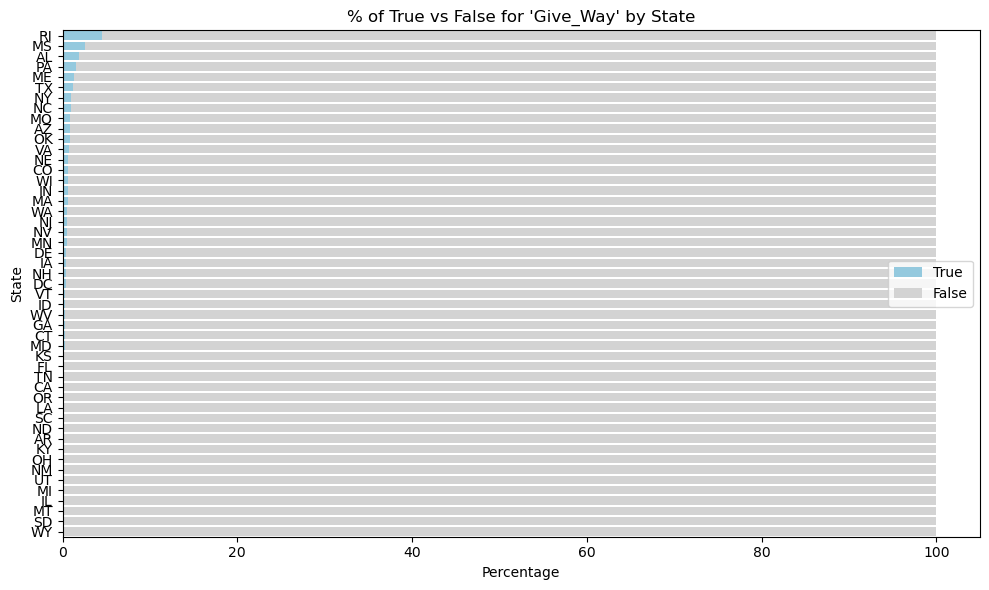


Top states for Junction:
   State     True_%    False_%
22    MO  14.517026  85.482974
37    RI  13.528961  86.471039
14    KS  13.376524  86.623476
6     DC  12.538916  87.461084
32    NY  12.243936  87.756064


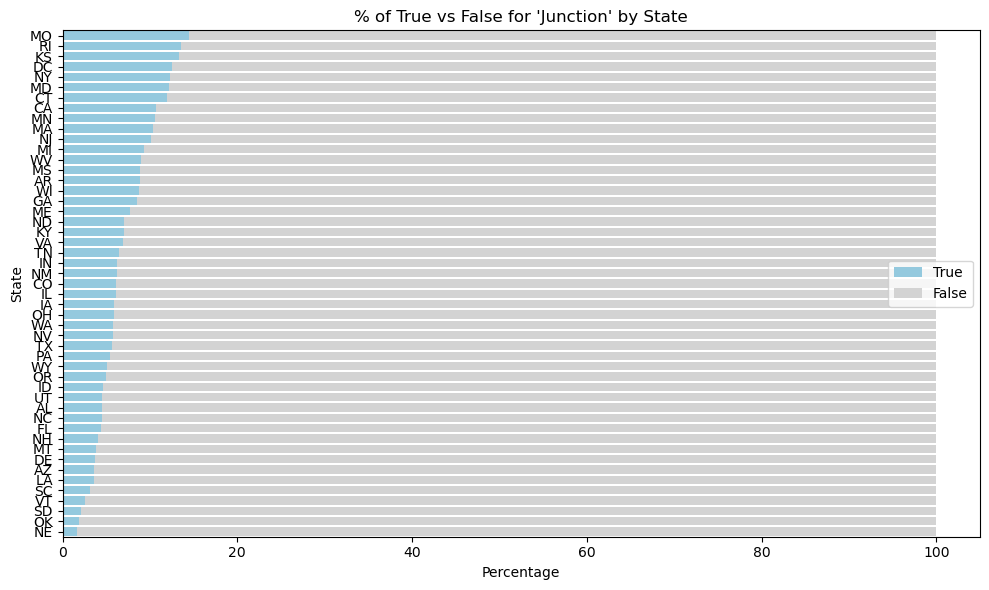


Top states for No_Exit:
   State    True_%    False_%
2     AZ  1.137103  98.862897
12    IL  0.903775  99.096225
34    OK  0.854783  99.145217
4     CO  0.740496  99.259504
11    ID  0.738397  99.261603


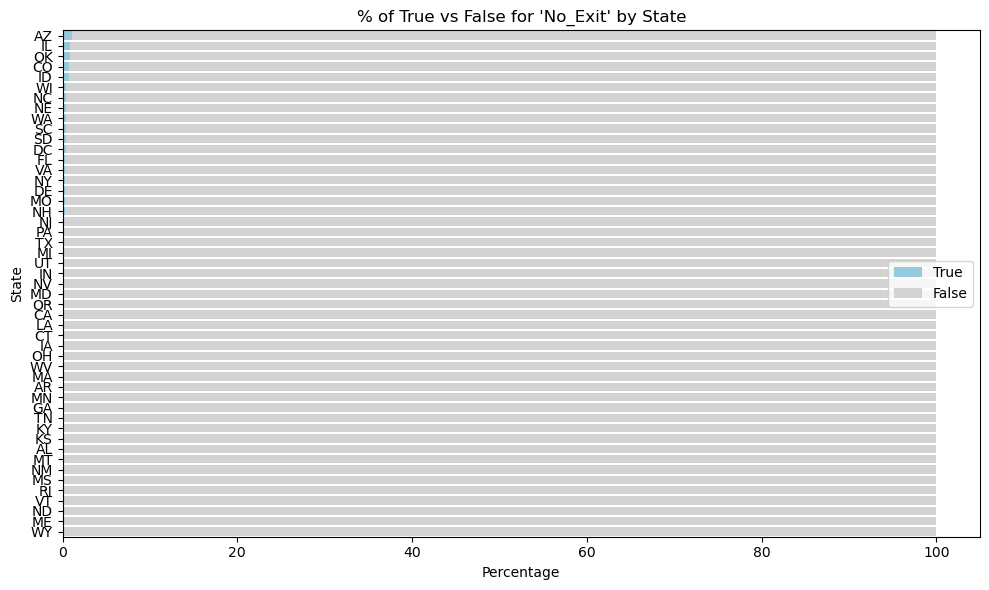


Top states for Railway:
   State    True_%    False_%
16    LA  2.596509  97.403491
12    IL  2.297021  97.702979
6     DC  2.259796  97.740204
45    WA  1.899816  98.100184
37    RI  1.667551  98.332449


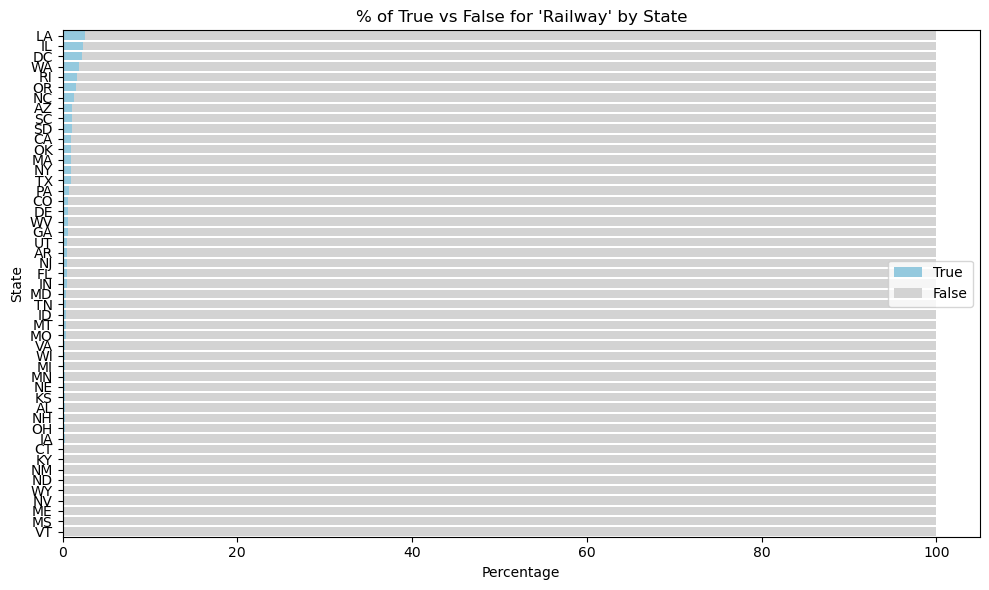


Top states for Roundabout:
   State    True_%    False_%
15    KY  0.049606  99.950394
45    WA  0.012936  99.987064
6     DC  0.010735  99.989265
30    NM  0.009685  99.990315
12    IL  0.008878  99.991122


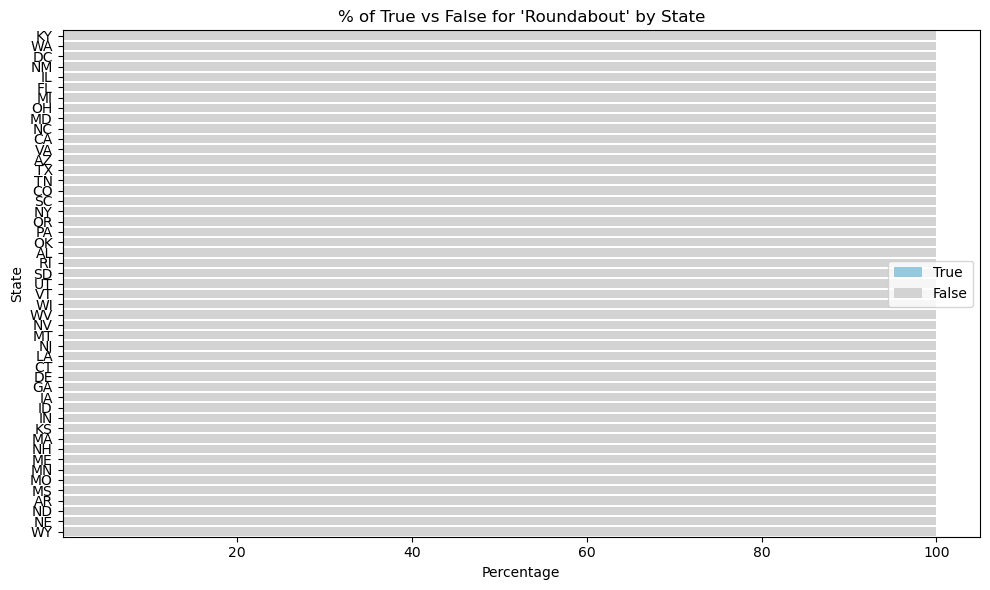


Top states for Station:
   State    True_%    False_%
17    MA  7.835989  92.164011
45    WA  6.469170  93.530830
8     FL  6.442912  93.557088
12    IL  6.324057  93.675943
6     DC  4.911433  95.088567


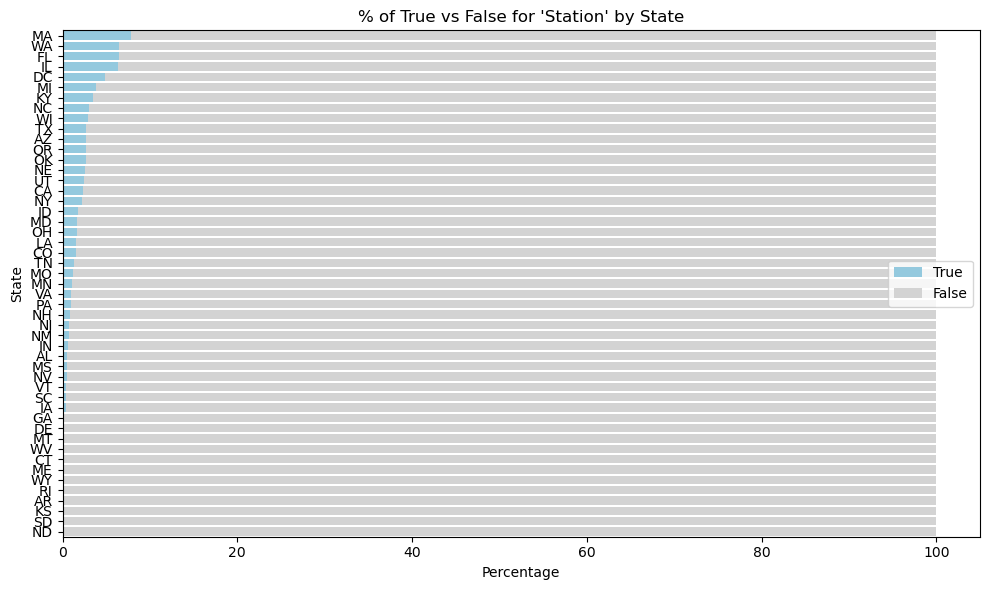


Top states for Stop:
   State     True_%    False_%
34    OK  14.163090  85.836910
2     AZ  10.720419  89.279581
28    NH   5.395085  94.604915
36    PA   5.089677  94.910323
27    NE   4.949775  95.050225


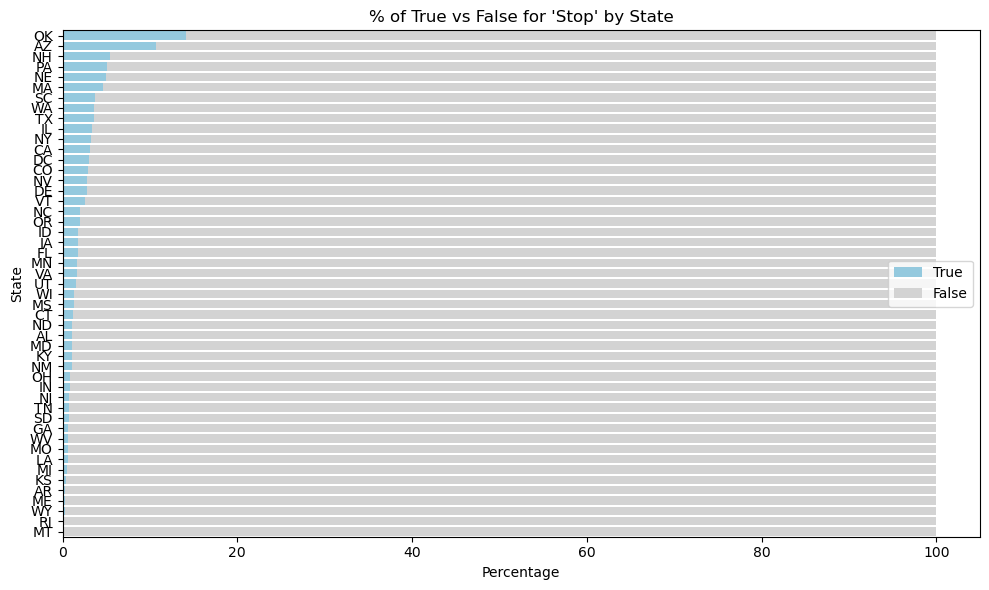


Top states for Traffic_Calming:
   State    True_%    False_%
2     AZ  0.439602  99.560398
18    MD  0.330444  99.669556
45    WA  0.246717  99.753283
34    OK  0.246273  99.753727
46    WI  0.219096  99.780904


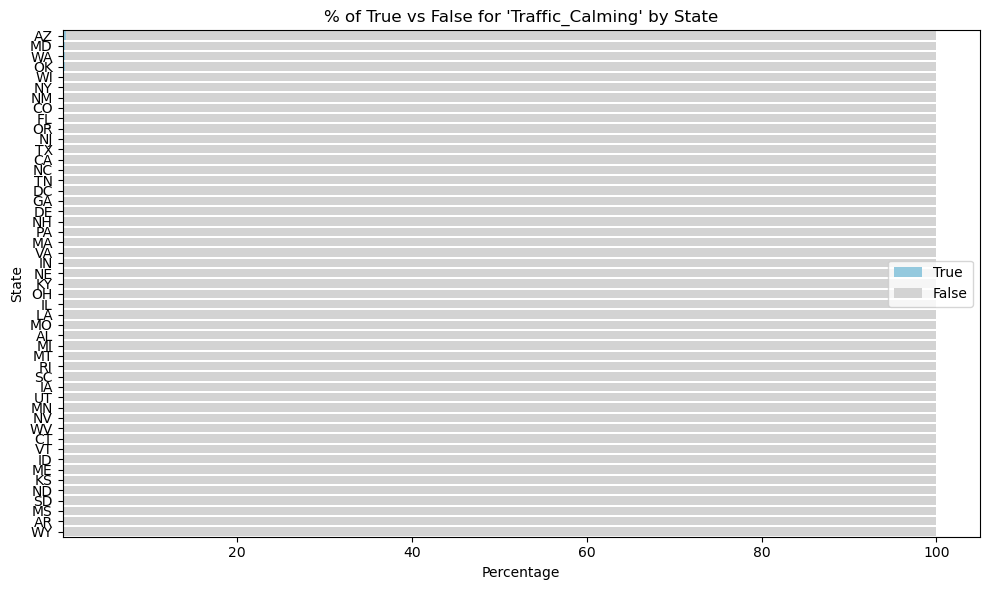


Top states for Traffic_Signal:
   State     True_%    False_%
27    NE  36.879113  63.120887
34    OK  35.191938  64.808062
12    IL  31.667042  68.332958
2     AZ  28.615724  71.384276
25    NC  27.229531  72.770469


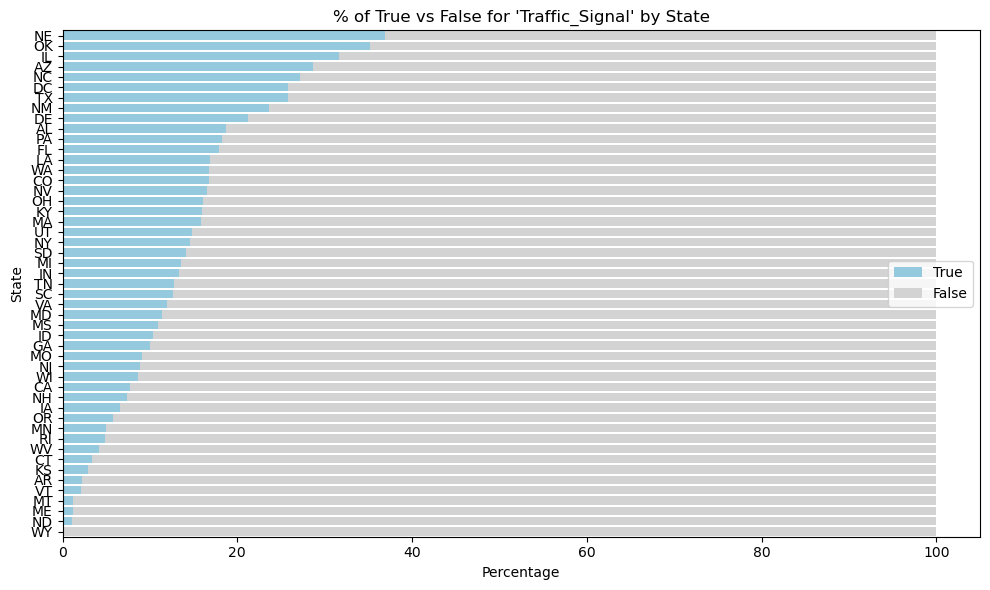


Top states for Turning_Loop:
   State  True_%  False_%
0     AL     0.0    100.0
25    NC     0.0    100.0
27    NE     0.0    100.0
28    NH     0.0    100.0
29    NJ     0.0    100.0


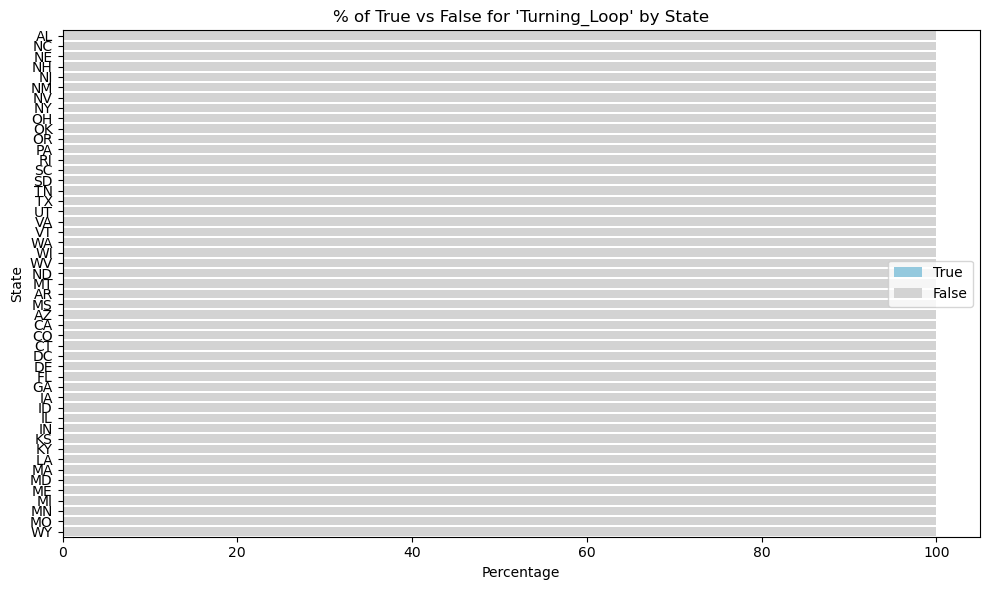

In [19]:
# Detect boolean columns
bool_cols = df.select_dtypes(include=["bool"]).columns.tolist()
print(f"Boolean columns: {bool_cols}")

# Confirm State column
state_col = "State"  # confirmed to exist

print("\nGenerating boolean %True/%False plots by State...")
for col in bool_cols:
    # Compute %True and %False
    pct_true = df.groupby(state_col)[col].mean() * 100
    pct_false = 100 - pct_true

    state_df = pd.DataFrame({
        "State": pct_true.index,
        "True_%": pct_true.values,
        "False_%": pct_false.values
    }).sort_values("True_%", ascending=False)

    # Display sample output
    print(f"\nTop states for {col}:")
    print(state_df.head())

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x="True_%", y="State", data=state_df, color='skyblue', label="True")
    sns.barplot(x="False_%", y="State", data=state_df, color='lightgray', label="False", left=state_df["True_%"])
    plt.title(f"% of True vs False for '{col}' by State")
    plt.xlabel("Percentage")
    plt.ylabel("State")
    plt.legend()
    plt.tight_layout()
    plt.show()


=== Boolean Feature Summary ===
                 True_Count  False_Count  True_%  False_%
Traffic_Signal      1143772      6584622  14.800   85.200
Crossing             873763      6854631  11.306   88.694
Junction             571342      7157052   7.393   92.607
Stop                 214371      7514023   2.774   97.226
Station              201901      7526493   2.612   97.388
Amenity               96334      7632060   1.246   98.754
Railway               66979      7661415   0.867   99.133
Give_Way              36582      7691812   0.473   99.527
No_Exit               19545      7708849   0.253   99.747
Traffic_Calming        7598      7720796   0.098   99.902
Bump                   3514      7724880   0.045   99.955
Roundabout              249      7728145   0.003   99.997
Turning_Loop              0      7728394   0.000  100.000


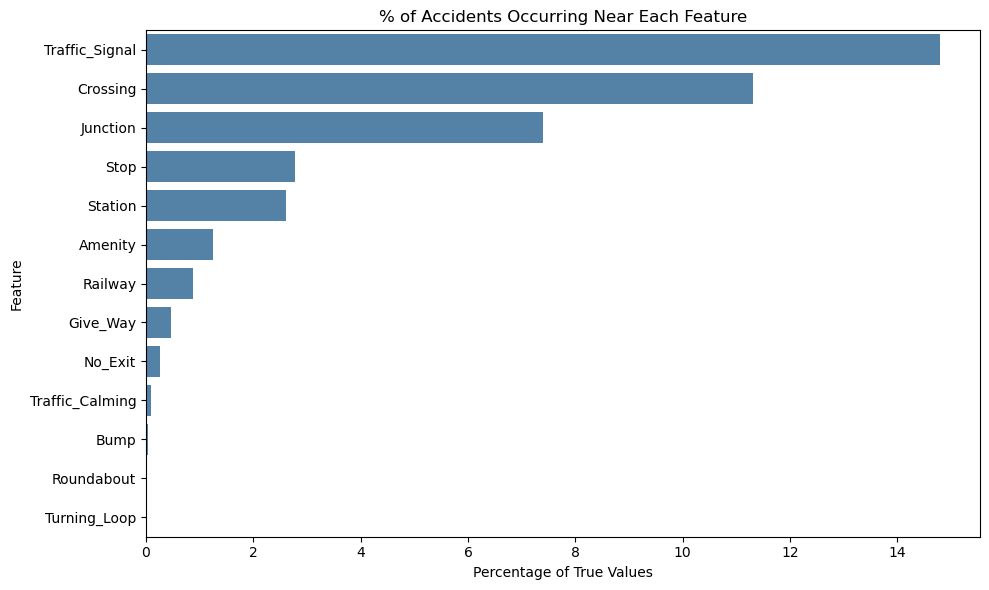

In [13]:
bool_cols = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 
             'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 
             'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

# Compute overall % of True values
bool_summary = pd.DataFrame({
    'True_Count': df[bool_cols].sum(),
    'False_Count': len(df) - df[bool_cols].sum()
})
bool_summary['True_%'] = (bool_summary['True_Count'] / len(df) * 100).round(3)
bool_summary['False_%'] = 100 - bool_summary['True_%']
bool_summary = bool_summary.sort_values('True_%', ascending=False)

print("=== Boolean Feature Summary ===")
print(bool_summary)

# --- Plot % True ---
plt.figure(figsize=(10, 6))
sns.barplot(x=bool_summary['True_%'], y=bool_summary.index, color='steelblue')
plt.title('% of Accidents Occurring Near Each Feature')
plt.xlabel('Percentage of True Values')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


=== Severity Distribution for Amenity ===
Severity     1      2      3     4
Amenity                           
False     0.86  79.51  16.97  2.66
True      1.43  92.27   4.18  2.11


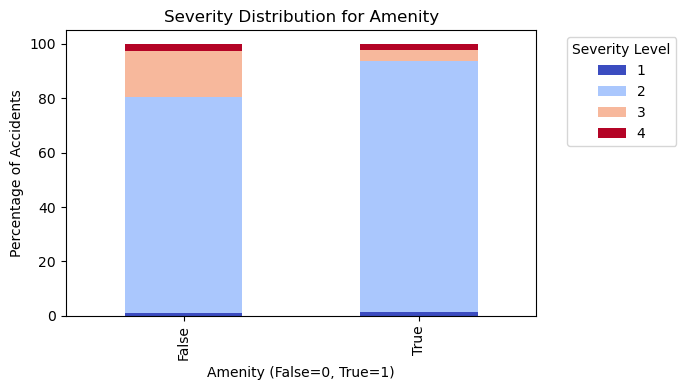


=== Severity Distribution for Bump ===
Severity     1      2      3     4
Bump                              
False     0.87  79.66  16.82  2.65
True      0.97  89.47   8.71  0.85


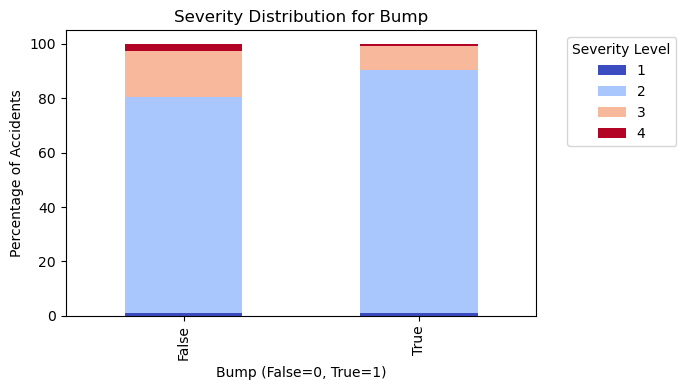


=== Severity Distribution for Crossing ===
Severity     1      2      3     4
Crossing                          
False     0.71  78.25  18.25  2.79
True      2.14  90.82   5.50  1.54


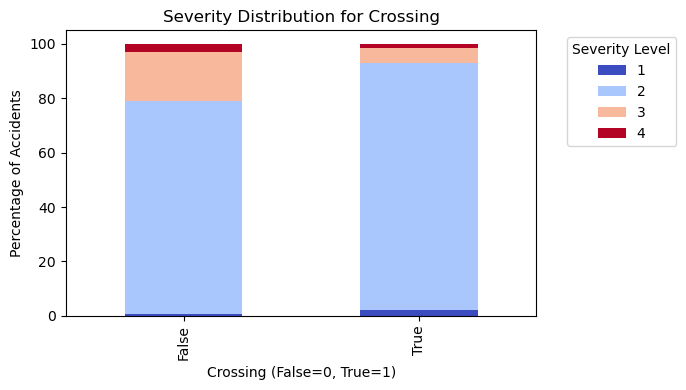


=== Severity Distribution for Give_Way ===
Severity     1      2      3     4
Give_Way                          
False     0.87  79.65  16.83  2.65
True      1.50  82.34  12.95  3.20


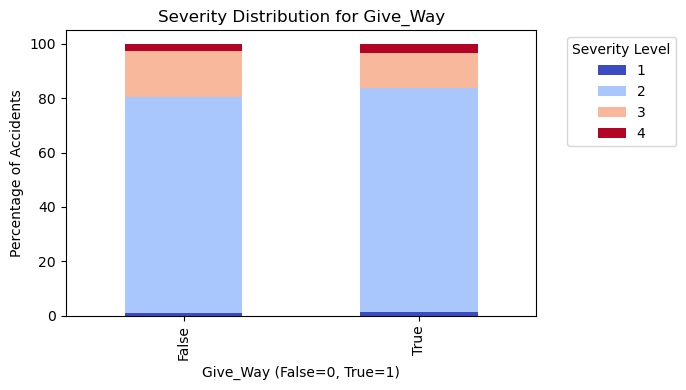


=== Severity Distribution for Junction ===
Severity     1      2      3     4
Junction                          
False     0.90  80.23  16.30  2.57
True      0.55  72.66  23.19  3.60


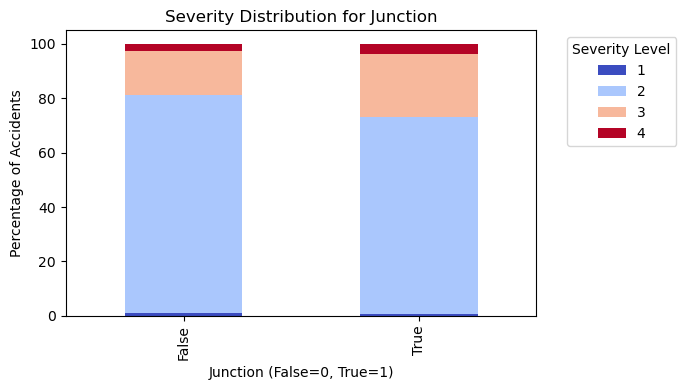


=== Severity Distribution for No_Exit ===
Severity     1      2      3     4
No_Exit                           
False     0.87  79.65  16.83  2.65
True      1.95  86.77   9.39  1.89


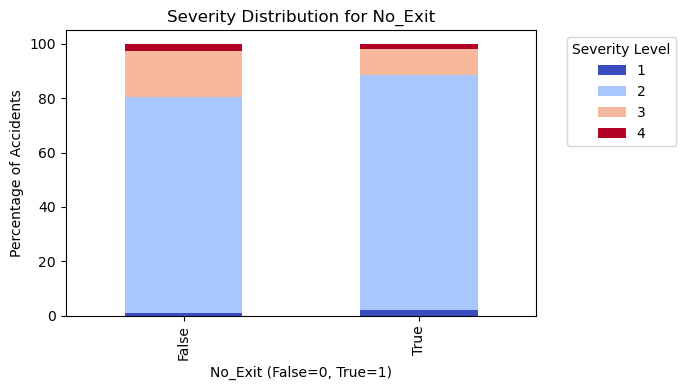


=== Severity Distribution for Railway ===
Severity     1      2      3     4
Railway                           
False     0.87  79.64  16.85  2.65
True      1.59  83.28  12.81  2.32


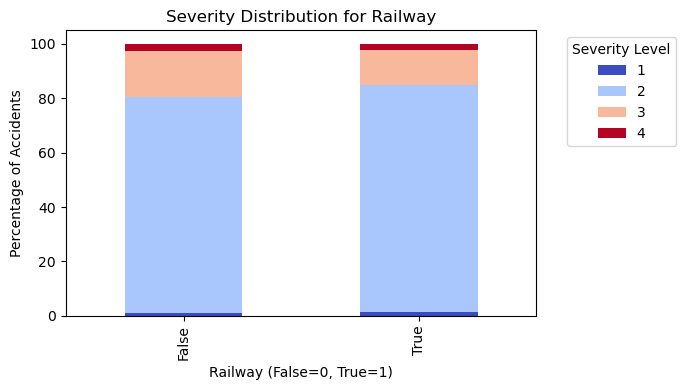


=== Severity Distribution for Roundabout ===
Severity       1      2      3     4
Roundabout                          
False       0.87  79.67  16.81  2.65
True        0.00  95.58   2.01  2.41


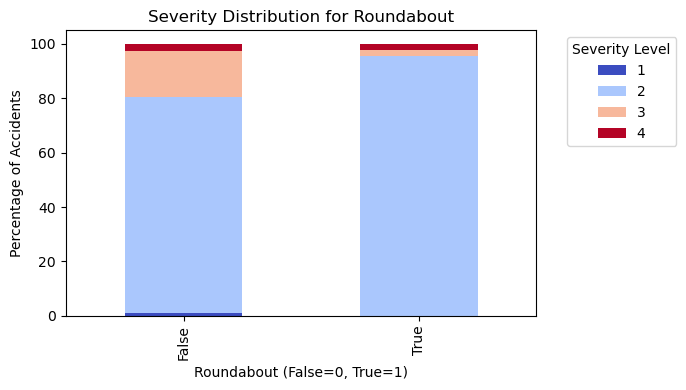


=== Severity Distribution for Station ===
Severity     1      2      3     4
Station                           
False     0.86  79.36  17.10  2.68
True      1.34  91.15   6.14  1.37


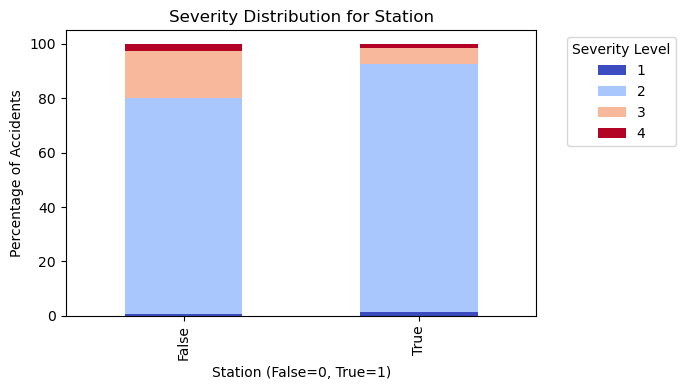


=== Severity Distribution for Stop ===
Severity     1      2      3     4
Stop                              
False     0.86  79.30  17.19  2.65
True      1.23  92.55   3.57  2.65


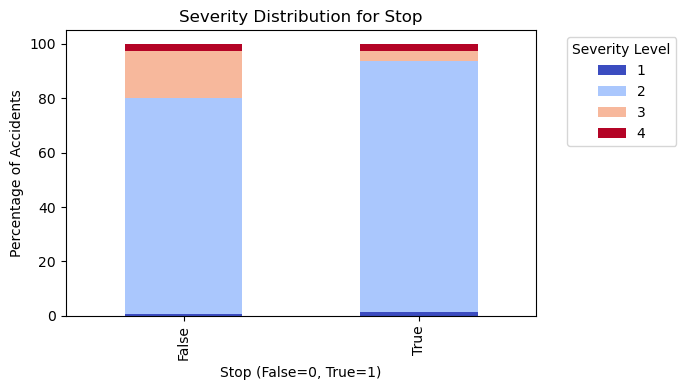


=== Severity Distribution for Traffic_Calming ===
Severity            1      2      3     4
Traffic_Calming                          
False            0.87  79.66  16.82  2.65
True             1.13  86.35  11.21  1.30


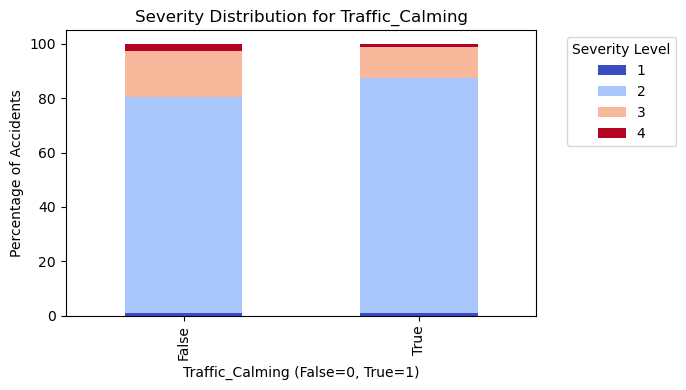


=== Severity Distribution for Traffic_Signal ===
Severity           1      2      3     4
Traffic_Signal                          
False           0.62  78.19  18.39  2.80
True            2.30  88.19   7.75  1.76


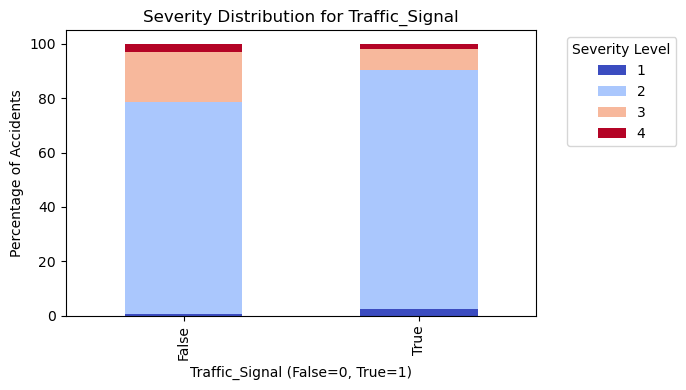


=== Severity Distribution for Turning_Loop ===
Severity         1      2      3     4
Turning_Loop                          
False         0.87  79.67  16.81  2.65


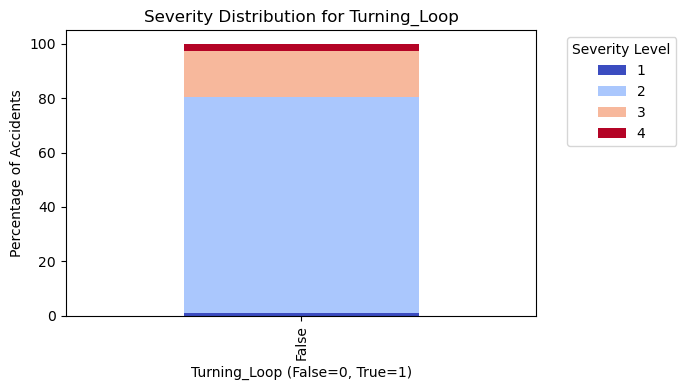

In [14]:
#Boolean Analysis
df['Severity'] = df['Severity'].astype(int)

# Loop through each boolean feature
for col in bool_cols:
    if col not in df.columns:
        continue

    # Group and count
    summary = (
        df.groupby([col, 'Severity'])
          .size()
          .unstack(fill_value=0)
          .apply(lambda x: x / x.sum() * 100, axis=1)  # percentage within True/False
    )

    print(f"\n=== Severity Distribution for {col} ===")
    print(summary.round(2))
    
    # --- Plot ---
    plt.figure(figsize=(7, 4))
    summary.plot(kind='bar', stacked=True, colormap='coolwarm', ax=plt.gca())
    plt.title(f"Severity Distribution for {col}")
    plt.xlabel(f"{col} (False=0, True=1)")
    plt.ylabel("Percentage of Accidents")
    plt.legend(title="Severity Level", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [20]:
from scipy.stats import mannwhitneyu

mean_sev = df.groupby(bool_cols)['Severity'].mean().sort_values(ascending=False)
print("\n=== Average Severity by Boolean Feature (True=1) ===")
print(mean_sev)

#Additional tests 
results = []

for col in bool_cols:
    if col not in df.columns:
        continue
    
    group_true = df.loc[df[col] == True, 'Severity']
    group_false = df.loc[df[col] == False, 'Severity']
    
    if len(group_true) < 10 or len(group_false) < 10:
        continue  # skip columns with too few samples
    
    stat, p_value = mannwhitneyu(group_true, group_false, alternative='two-sided')
    
    mean_true = group_true.mean()
    mean_false = group_false.mean()
    
    results.append({
        'Feature': col,
        'Mean_Severity_True': round(mean_true, 2),
        'Mean_Severity_False': round(mean_false, 2),
        'Mean_Difference': round(mean_true - mean_false, 2),
        'p-value': round(p_value, 5),
        'Significant (p<0.05)': p_value < 0.05
    })

# Convert to DataFrame
sig_df = pd.DataFrame(results).sort_values('p-value')
print(sig_df)



=== Average Severity by Boolean Feature (True=1) ===
Amenity  Bump   Crossing  Give_Way  Junction  No_Exit  Railway  Roundabout  Station  Stop   Traffic_Calming  Traffic_Signal  Turning_Loop
True     False  True      True      False     False    False    False       True     False  True             True            False           4.000000
                          False     False     True     True     False       False    False  False            False           False           3.333333
False    False  True      False     True      True     False    False       False    True   False            True            False           3.000000
                                              False    False    False       False    True   True             False           False           3.000000
True     True   False     False     False     False    False    False       True     True   True             False           False           3.000000
                                                          

In [25]:
#Boolean Correlation

effect_size_results = []

for col in bool_cols:
    true_vals = df[df[col] == True]['Severity']
    false_vals = df[df[col] == False]['Severity']

    # Skip if either group has no samples
    if true_vals.empty or false_vals.empty:
        print(f"Skipping {col} — no variation (all True or all False).")
        continue

    # Mann–Whitney test
    stat, p = mannwhitneyu(true_vals, false_vals, alternative='two-sided')

    # Cohen’s d
    d = (true_vals.mean() - false_vals.mean()) / np.sqrt(
        ((true_vals.std() ** 2) + (false_vals.std() ** 2)) / 2
    )

    # Rank–Biserial correlation
    n1, n2 = len(true_vals), len(false_vals)
    r_rb = 1 - (2 * stat) / (n1 * n2)

    effect_size_results.append({
        'Feature': col,
        'Mean_Severity_True': true_vals.mean(),
        'Mean_Severity_False': false_vals.mean(),
        'Mean_Difference': true_vals.mean() - false_vals.mean(),
        'p-value': p,
        'Cohens_d': d,
        'Rank_Biserial_r': r_rb,
        'Significant (p<0.05)': p < 0.05
    })

effect_size_df = pd.DataFrame(effect_size_results)
effect_size_df = effect_size_df.sort_values(by='Cohens_d', ascending=False)

print(effect_size_df)

Skipping Turning_Loop — no variation (all True or all False).
            Feature  Mean_Severity_True  Mean_Severity_False  Mean_Difference  \
4          Junction            2.298471             2.205512         0.092959   
3          Give_Way            2.178558             2.212545        -0.033988   
6           Railway            2.158662             2.212854        -0.054192   
10  Traffic_Calming            2.126875             2.212469        -0.085593   
5           No_Exit            2.112151             2.212639        -0.100487   
1              Bump            2.094479             2.212438        -0.117959   
9              Stop            2.076419             2.216264        -0.139845   
11   Traffic_Signal            2.089675             2.233700        -0.144024   
8           Station            2.075364             2.216060        -0.140696   
0           Amenity            2.069726             2.214185        -0.144459   
7        Roundabout            2.068273        

C:\Users\fokunlola\AppData\Local\Temp\ipykernel_15744\3334010574.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


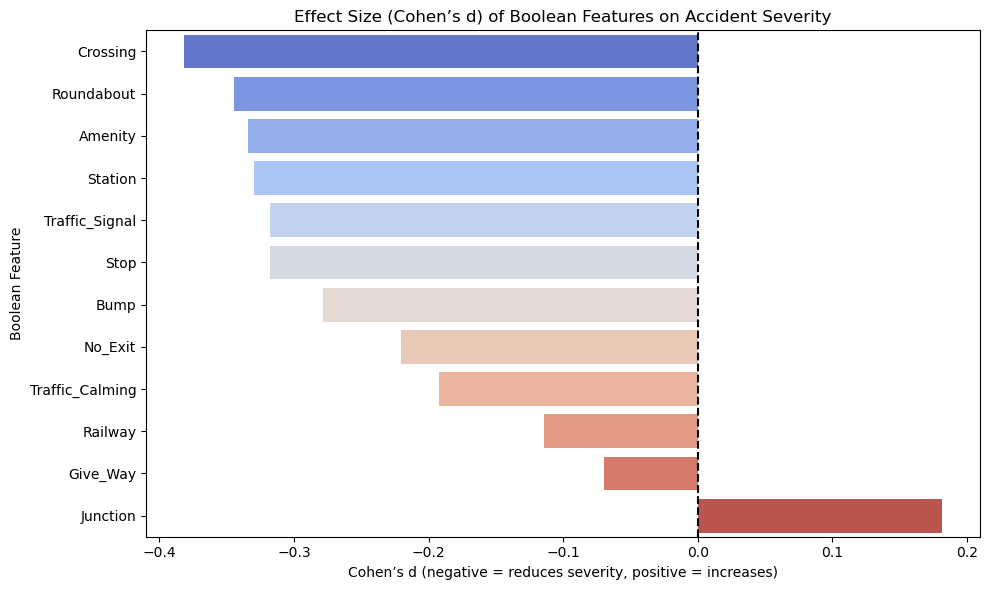

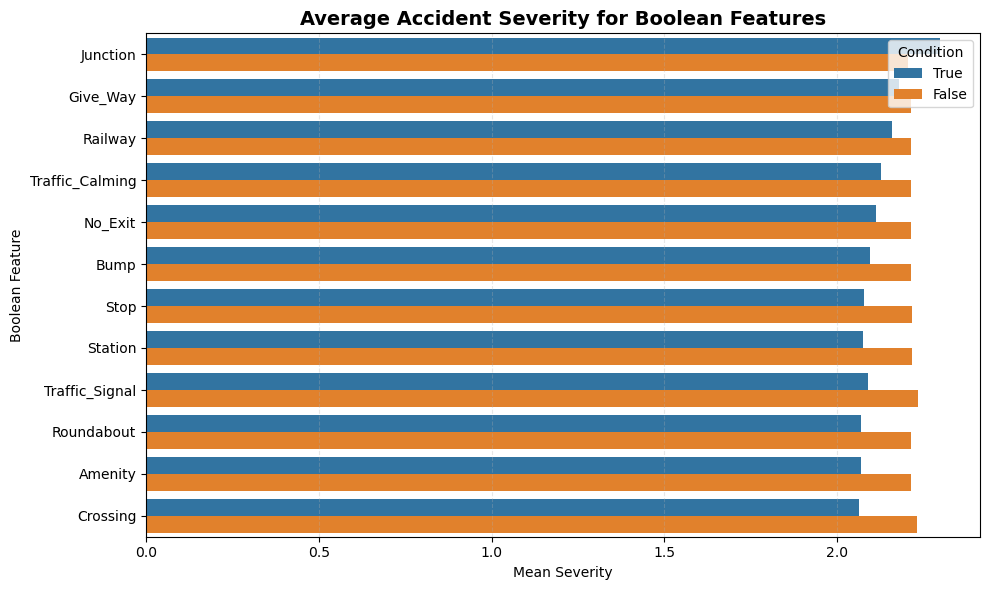

In [27]:
plt.figure(figsize=(10,6))
sns.barplot(
    x='Cohens_d', 
    y='Feature', 
    data=effect_size_df.sort_values(by='Cohens_d'),
    palette='coolwarm'
)
plt.axvline(0, color='black', linestyle='--')
plt.title("Effect Size (Cohen’s d) of Boolean Features on Accident Severity")
plt.xlabel("Cohen’s d (negative = reduces severity, positive = increases)")
plt.ylabel("Boolean Feature")
plt.tight_layout()
plt.show()

# Ensure dataframe is sorted by mean difference
effect_size_df_sorted = effect_size_df.sort_values("Mean_Difference", ascending=False)

# Melt dataframe to long format for plotting
plot_df = effect_size_df_sorted.melt(
    id_vars=["Feature"],
    value_vars=["Mean_Severity_True", "Mean_Severity_False"],
    var_name="Condition",
    value_name="Mean_Severity"
)

# Clean condition labels for readability
plot_df["Condition"] = plot_df["Condition"].replace({
    "Mean_Severity_True": "True",
    "Mean_Severity_False": "False"
})

# Set up plot
plt.figure(figsize=(10,6))
sns.barplot(
    x="Mean_Severity", 
    y="Feature", 
    hue="Condition", 
    data=plot_df,
    palette=["#1f77b4", "#ff7f0e"]
)

# Add details
plt.title("Average Accident Severity for Boolean Features", fontsize=14, weight="bold")
plt.xlabel("Mean Severity")
plt.ylabel("Boolean Feature")
plt.legend(title="Condition", loc="upper right")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
# Detect categorical columns
TOP_N = 20

cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
EXCLUDE_COLS = [
    "ID", "Description", "Country", "Zipcode", 
    "Street", "Airport_Code", "City", "County"
]
print(f"\nDetected {len(cat_cols)} categorical columns: {cat_cols}")

cat_cols = [c for c in cat_cols if c not in EXCLUDE_COLS]
print(f"\nDetected {len(cat_cols)} categorical columns after filtering: {cat_cols}")

print("\nGenerating total-level category distribution charts...")

for col in cat_cols:
    print(f"\nProcessing '{col}'...")

    # Count categories and compute percentages
    cat_counts = df[col].value_counts(dropna=False)
    cat_percent = (cat_counts / len(df)) * 100
    cat_df = pd.DataFrame({
        "Category": cat_counts.index.astype(str),
        "Count": cat_counts.values,
        "Percentage": cat_percent.values
    })

    # Save CSV summary
    csv_path = os.path.join(OUTPUT_DIR, f"cat_total_{col}.csv")
    cat_df.to_csv(csv_path, index=False)

    # Plot top N categories
    if PLOT:
        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=cat_df.head(TOP_N),
            x="Percentage",
            y="Category",
            hue="Category",   
            palette="viridis",
            legend=False
        )
        plt.title(f"Top {TOP_N} categories for '{col}'")
        plt.xlabel("Percentage of Total Records (%)")
        plt.ylabel("Category")
        plt.tight_layout()

        # Save and show
        fig_path = os.path.join(OUTPUT_DIR, f"cat_total_{col}.png")
        plt.savefig(fig_path, bbox_inches="tight")
        plt.show()
        plt.close()

    print(f"✓ Saved: {csv_path}")

print("\n✅ All filtered categorical charts and CSVs generated successfully.")


Detected 18 categorical columns: ['ID', 'Source', 'End_Time', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Wind_Direction', 'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

Detected 10 categorical columns after filtering: ['Source', 'End_Time', 'State', 'Timezone', 'Wind_Direction', 'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

Generating total-level category distribution charts...

Processing 'Source'...


NameError: name 'OUTPUT_DIR' is not defined

In [ ]:
# ===================== CONDITIONAL PROBABILITIES =====================
if "Severity" in df.columns:
    prob_by_weather = pd.crosstab(df["Weather_Condition"], df["Severity"], normalize='index')
    prob_by_weather.to_csv(os.path.join(OUTPUT_DIR, "prob_by_weather.csv"))
    print("\nConditional probability P(Severity|Weather_Condition) saved.")

# ===================== SAVE CLEANED DATA SAMPLE =====================
df.sample(1000, random_state=42).to_csv(os.path.join(OUTPUT_DIR, "cleaned_sample.csv"), index=False)
print("\n✅ Full EDA complete. Outputs saved in", OUTPUT_DIR)


In [ ]:
# Dropping rows with unknown columns

Severity                 1.000000
Source                   0.208813
End_Lng                  0.121178
Start_Lat                0.069060
Weather_Condition        0.066786
End_Lat                  0.056135
Start_Lng                0.052862
Junction                 0.049890
Pressure(in)             0.042152
Wind_Speed(mph)          0.035751
Distance(mi)             0.034787
Wind_Direction           0.025633
Humidity(%)              0.022079
State                    0.021418
Civil_Twilight           0.009407
Nautical_Twilight        0.009324
Precipitation(in)        0.009159
Sunrise_Sunset           0.009056
Astronomical_Twilight    0.006456
Roundabout              -0.001678
Visibility(mi)          -0.002804
Give_Way                -0.004785
Bump                    -0.005158
Traffic_Calming         -0.005502
Railway                 -0.010303
No_Exit                 -0.010352
Temperature(F)          -0.019966
Amenity                 -0.032875
Wind_Chill(F)           -0.041381
Station       

C:\Users\fokunlola\AppData\Local\Temp\ipykernel_1652\3410337755.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')


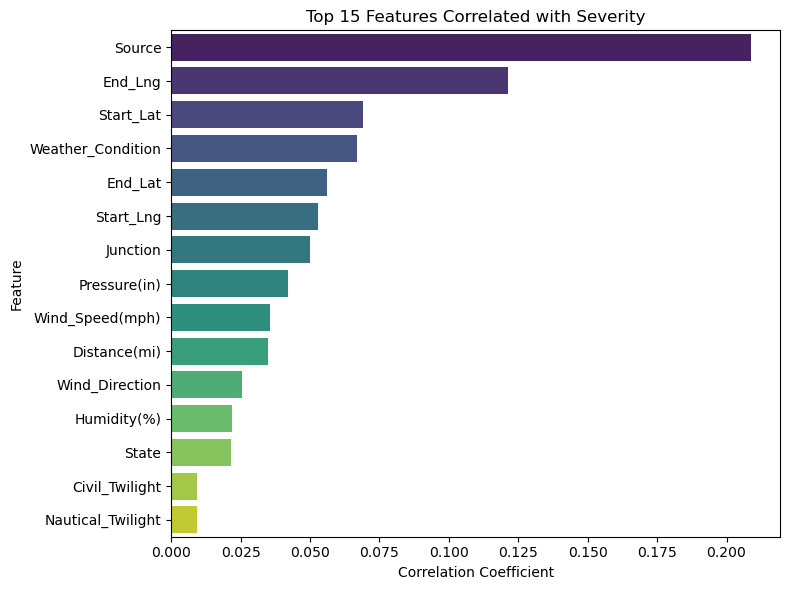

In [27]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Identify column types
num_cols = df.select_dtypes(include=['int32', 'float64']).columns.tolist()
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Exclude unwanted columns
exclude = ['ID', 'Description', 'Country', 'Zipcode', 'Street', 'Airport_Code', 'City', 'County']
cat_cols = [c for c in cat_cols if c not in exclude]

# Encode categorical columns
le = LabelEncoder()
encoded_df = df.copy()
for col in cat_cols:
    encoded_df[col] = le.fit_transform(encoded_df[col].astype(str))

# Convert boolean to int
encoded_df[bool_cols] = encoded_df[bool_cols].astype(int)

# Compute correlations with Severity
corr = encoded_df.corr(numeric_only=True)['Severity'].sort_values(ascending=False)

# Display correlation values
print(corr)

# Plot top correlated features (excluding Severity itself)
corr = corr.drop('Severity')
top_corr = corr.head(15)

plt.figure(figsize=(8,6))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')
plt.title('Top 15 Features Correlated with Severity')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


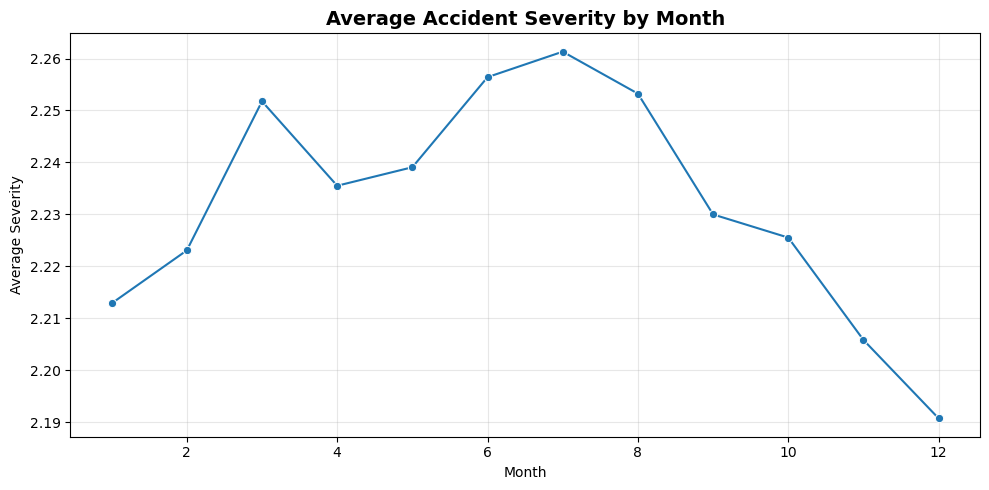

C:\Users\fokunlola\AppData\Local\Temp\ipykernel_15744\2619723149.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Month", y="Severity", palette="coolwarm")


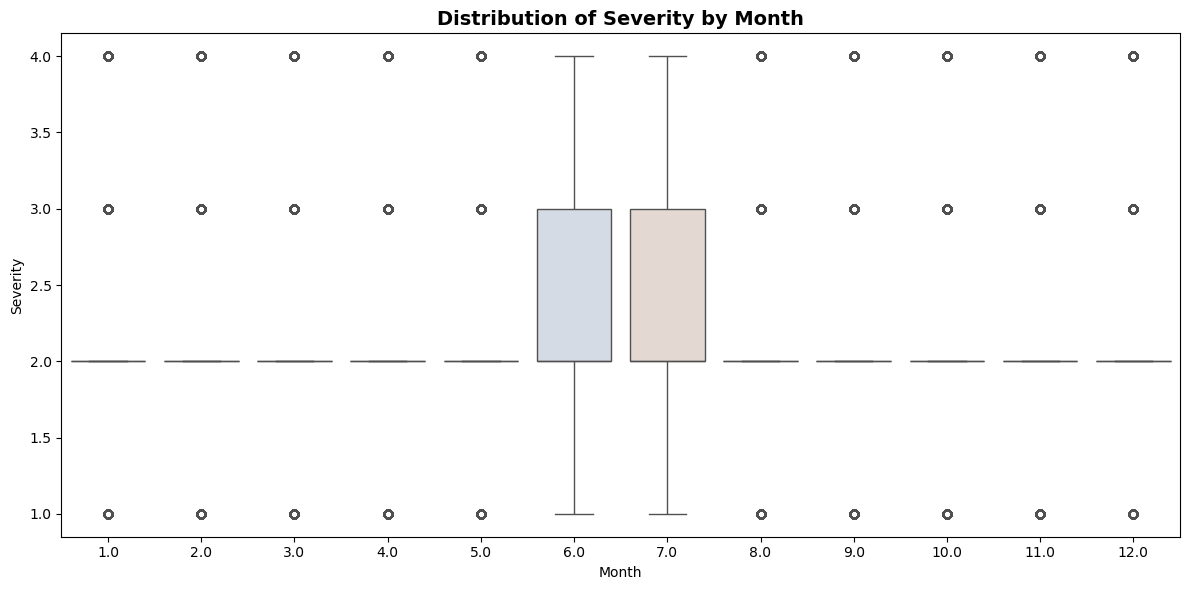


Correlation of Severity with Time-based Features:
Severity    1.000000
Hour        0.018479
Day        -0.000155
Month      -0.015949
Year       -0.232329
Name: Severity, dtype: float64


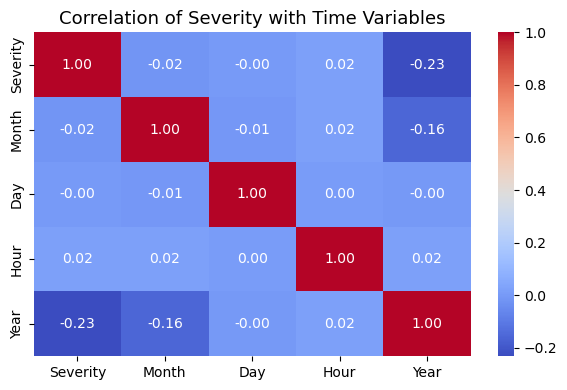

In [3]:
#To check month correlation
df["Start_Time"] = pd.to_datetime(df["Start_Time"], errors="coerce")

# Extract time features
df["Year"] = df["Start_Time"].dt.year
df["Month"] = df["Start_Time"].dt.month
df["Day"] = df["Start_Time"].dt.day
df["Hour"] = df["Start_Time"].dt.hour

# Average Severity by Month
monthly_severity = df.groupby("Month")["Severity"].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_severity, x="Month", y="Severity", marker="o")
plt.title("Average Accident Severity by Month", fontsize=14, weight='bold')
plt.xlabel("Month")
plt.ylabel("Average Severity")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Distribution of Severity per Month
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Month", y="Severity", palette="coolwarm")
plt.title("Distribution of Severity by Month", fontsize=14, weight='bold')
plt.xlabel("Month")
plt.ylabel("Severity")
plt.tight_layout()
plt.show()

# Correlation between Time Features and Severity 
time_corr = df[["Severity", "Month", "Day", "Hour", "Year"]].corr()
print("\nCorrelation of Severity with Time-based Features:")
print(time_corr["Severity"].sort_values(ascending=False))

# Visualize correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(time_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Severity with Time Variables", fontsize=13)
plt.tight_layout()
plt.show()

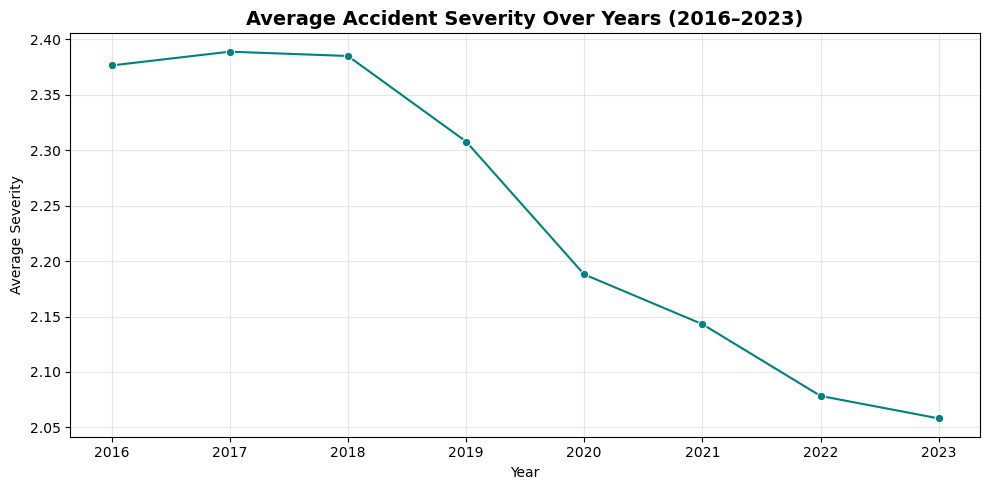

In [4]:
# Average Severity by Year
yearly_severity = df.groupby("Year")["Severity"].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=yearly_severity, x="Year", y="Severity", marker="o", color="teal")
plt.title("Average Accident Severity Over Years (2016–2023)", fontsize=14, weight='bold')
plt.xlabel("Year")
plt.ylabel("Average Severity")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

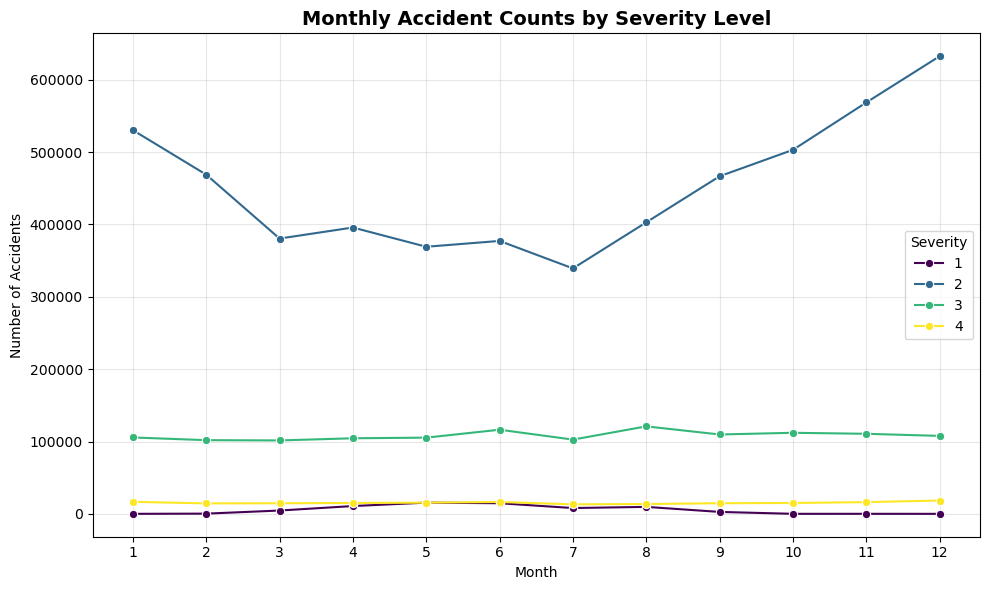

C:\Users\fokunlola\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\fokunlola\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\fokunlola\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\fokunlola\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


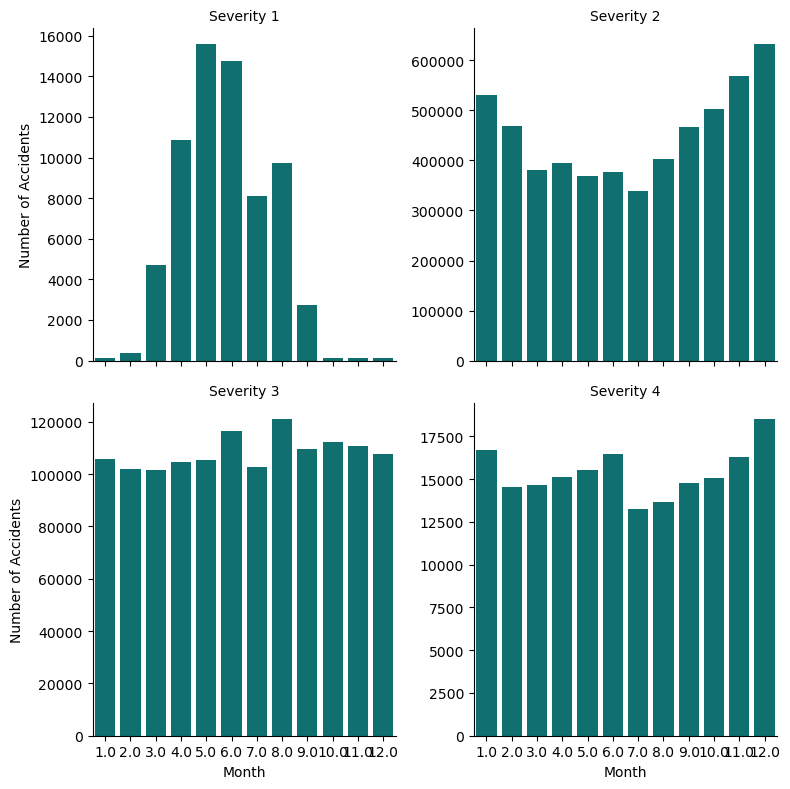

In [10]:
# Extract Month and Year for grouping
df["Year"] = df["Start_Time"].dt.year
df["Month"] = df["Start_Time"].dt.month

# Group by Month and Severity
monthly_counts = (
    df.groupby(["Year", "Month", "Severity"])
    .size()
    .reset_index(name="Count")
)

# : Trend of each severity level across all months (combined over years)
monthly_trend = (
    df.groupby(["Month", "Severity"])
    .size()
    .reset_index(name="Count")
)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=monthly_trend,
    x="Month",
    y="Count",
    hue="Severity",
    marker="o",
    palette="viridis"
)
plt.title("Monthly Accident Counts by Severity Level", fontsize=14, weight='bold')
plt.xlabel("Month")
plt.ylabel("Number of Accidents")
plt.xticks(range(1,13))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#  Facet by severity (each severity on its own chart)
g = sns.FacetGrid(monthly_trend, col="Severity", col_wrap=2, height=4, sharey=False)
g.map_dataframe(sns.barplot, x="Month", y="Count", color="teal", ci=None)  # removed marker, added ci=None
g.set_titles("Severity {col_name}")
g.set_axis_labels("Month", "Number of Accidents")
g.tight_layout()
plt.show()

In [12]:
# Monthly Counts =====
monthly_table = (
    df.groupby(["Month", "Severity"])
    .size()
    .unstack(fill_value=0)
    .astype(int)
)
monthly_table["Total"] = monthly_table.sum(axis=1)

# Compute % share of each severity level
monthly_percent = monthly_table.div(monthly_table["Total"], axis=0) * 100
monthly_percent = monthly_percent.round(2)
monthly_percent = monthly_percent.add_suffix(" (%)")

# Combine count and percentage tables side by side
monthly_summary = pd.concat([monthly_table, monthly_percent], axis=1)

print("\n===Accident Counts and Percentage by Month and Severity ===")
print(monthly_summary)

# Yearly Counts =====
yearly_table = (
    df.groupby(["Year", "Severity"])
    .size()
    .unstack(fill_value=0)
    .astype(int)
)
yearly_table["Total"] = yearly_table.sum(axis=1)

# Compute % share of each severity level
yearly_percent = yearly_table.div(yearly_table["Total"], axis=0) * 100
yearly_percent = yearly_percent.round(2)
yearly_percent = yearly_percent.add_suffix(" (%)")

# Combine count and percentage tables side by side
yearly_summary = pd.concat([yearly_table, yearly_percent], axis=1)

print("\n=== Accident Counts and Percentage by Year and Severity ===")
print(yearly_summary)


===Accident Counts and Percentage by Month and Severity ===
Severity      1       2       3      4   Total  1 (%)  2 (%)  3 (%)  4 (%)  \
Month                                                                        
1.0         114  530231  105637  16700  652682   0.02  81.24  16.19   2.56   
2.0         391  468760  101895  14560  585606   0.07  80.05  17.40   2.49   
3.0        4686  380456  101530  14690  501362   0.93  75.88  20.25   2.93   
4.0       10860  395703  104509  15138  526210   2.06  75.20  19.86   2.88   
5.0       15584  369106  105386  15538  505614   3.08  73.00  20.84   3.07   
6.0       14759  377169  116330  16492  524750   2.81  71.88  22.17   3.14   
7.0        8119  339209  102689  13246  463263   1.75  73.22  22.17   2.86   
8.0        9714  402871  120954  13667  547206   1.78  73.62  22.10   2.50   
9.0        2763  466519  109737  14796  593815   0.47  78.56  18.48   2.49   
10.0        129  503008  112097  15091  630325   0.02  79.80  17.78   2.39   
11.

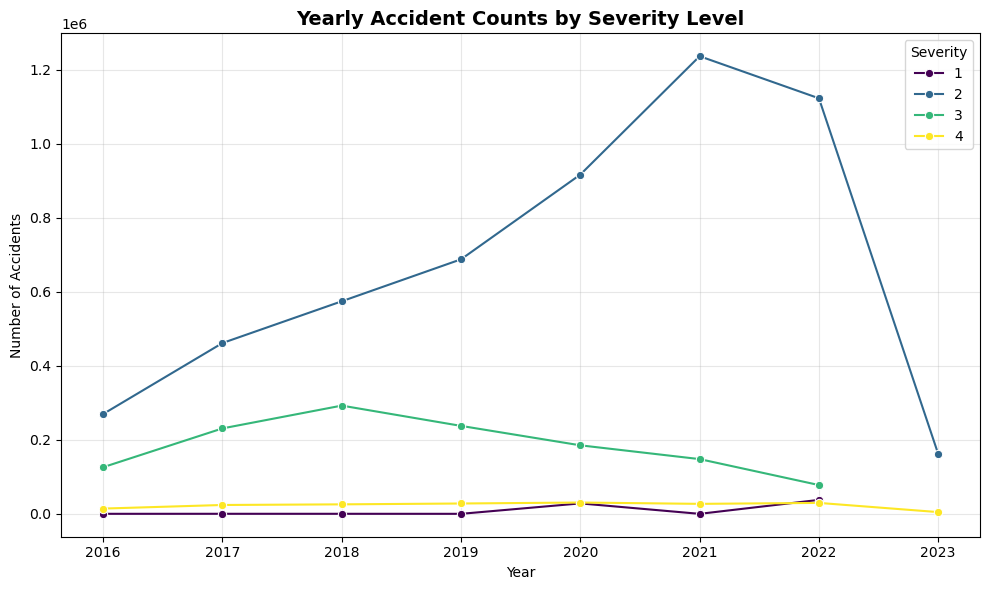

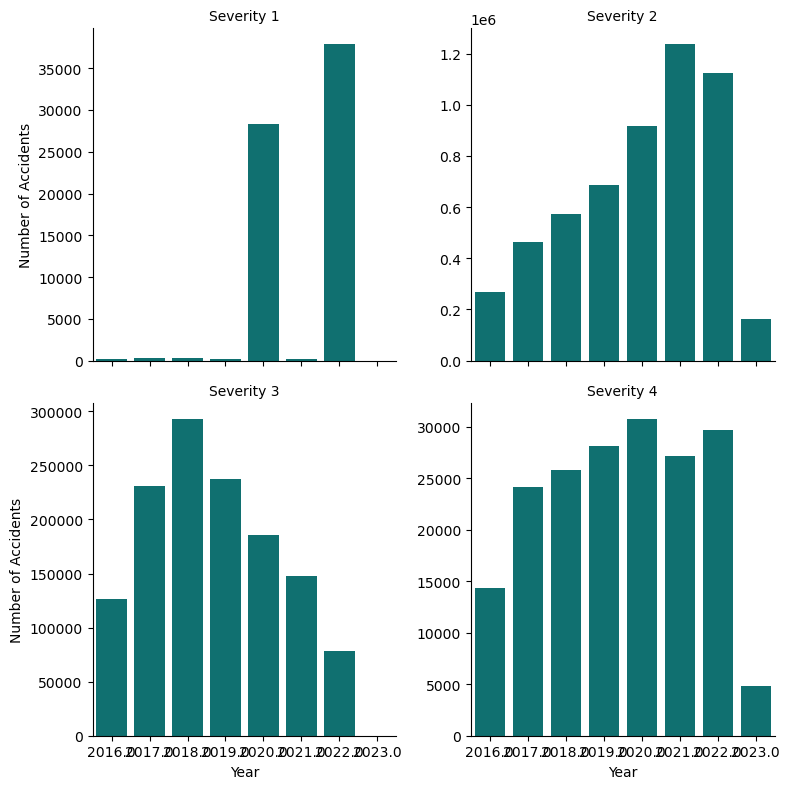

In [9]:
# Extract Year
df["Year"] = df["Start_Time"].dt.year

# Group by Year and Severity
yearly_trend = (
    df.groupby(["Year", "Severity"])
    .size()
    .reset_index(name="Count")
)

# Combined Trend (All Severities) =====
plt.figure(figsize=(10,6))
sns.lineplot(
    data=yearly_trend,
    x="Year",
    y="Count",
    hue="Severity",
    marker="o",
    palette="viridis"
)
plt.title("Yearly Accident Counts by Severity Level", fontsize=14, weight='bold')
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#Faceted Trend (Each Severity Separately) =====
g = sns.FacetGrid(yearly_trend, col="Severity", col_wrap=2, height=4, sharey=False)
g.map_dataframe(sns.barplot, x="Year", y="Count", color="teal")  # changed from lineplot to barplot
g.set_titles("Severity {col_name}")
g.set_axis_labels("Year", "Number of Accidents")
g.tight_layout()
plt.show()

In [28]:
# feature_relevance_severity.py
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import os


os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------------------------------------------------
# Helper functions
# -------------------------------------------------------------
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    denom = min((kcorr - 1), (rcorr - 1))
    if denom == 0:
        return np.nan
    return np.sqrt(phi2corr / denom)

# -------------------------------------------------------------
# Load data (you already have df in memory, so comment next line if needed)
# df = pd.read_parquet("US_Accidents_Dec21_updated.parquet")
# -------------------------------------------------------------

# Ensure Severity exists
assert "Severity" in df.columns, "Severity column not found in dataframe."

# Split numeric and categorical features
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = [c for c in num_cols if c != "Severity"]

# =============================================================
# 1️⃣ Correlation & Association with Severity
# =============================================================

print("\n=== Computing correlations with Severity ===")
corr_results = {}
for col in num_cols:
    valid = df[[col, "Severity"]].dropna()
    if len(valid) < 10:
        continue
    r, p = spearmanr(valid[col], valid["Severity"])
    corr_results[col] = {"Spearman_r": r, "p_value": p}

corr_df = pd.DataFrame(corr_results).T.sort_values("Spearman_r", ascending=False)
corr_df.to_csv(os.path.join(OUTPUT_DIR, "numeric_correlation_with_severity.csv"))
print("Top correlated numeric features:\n", corr_df.head(10))

# Association (Cramér’s V) for categorical columns
print("\n=== Computing Cramér’s V for categorical features ===")
assoc = {}
for col in cat_cols:
    try:
        v = cramers_v(df[col].fillna("Unknown"), df["Severity"])
        assoc[col] = v
    except Exception:
        assoc[col] = np.nan

assoc_df = pd.DataFrame.from_dict(assoc, orient="index", columns=["Cramers_V"])
assoc_df = assoc_df.sort_values("Cramers_V", ascending=False)
assoc_df.to_csv(os.path.join(OUTPUT_DIR, "categorical_association_with_severity.csv"))
print("Top categorical associations:\n", assoc_df.head(10))

# =============================================================
# 2️⃣ Mutual Information (captures nonlinear relevance)
# =============================================================
print("\n=== Computing Mutual Information ===")

# Prepare data for MI
X_mi = df[num_cols + cat_cols].copy()
y_mi = df["Severity"].copy()

# Encode categoricals numerically
for c in cat_cols:
    le = LabelEncoder()
    X_mi[c] = le.fit_transform(X_mi[c].astype(str))

# Fill remaining missing
imp = SimpleImputer(strategy="most_frequent")
X_mi = pd.DataFrame(imp.fit_transform(X_mi), columns=X_mi.columns)

mi_scores = mutual_info_classif(X_mi, y_mi, discrete_features='auto', random_state=42)
mi_df = pd.DataFrame({"Feature": X_mi.columns, "MI_Score": mi_scores})
mi_df = mi_df.sort_values("MI_Score", ascending=False)
mi_df.to_csv(os.path.join(OUTPUT_DIR, "mutual_information_with_severity.csv"))
print("Top features by mutual information:\n", mi_df.head(10))

if True:  # plot MI
    plt.figure(figsize=(8, 10))
    sns.barplot(data=mi_df.head(20), x="MI_Score", y="Feature", color='skyblue')
    plt.title("Top 20 Features by Mutual Information with Severity")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "mutual_information_plot.png"))
    plt.close()

# 
# Model-based Feature Importance (Random Forest)

print("\n=== Training RandomForest to get feature importances ===")
# Encode data
X = X_mi.copy()
y = y_mi.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values("Importance", ascending=False)

feat_imp.to_csv(os.path.join(OUTPUT_DIR, "rf_feature_importances.csv"), index=False)
print("Top features by Random Forest importance:\n", feat_imp.head(10))

if True:
    plt.figure(figsize=(8, 10))
    sns.barplot(data=feat_imp.head(20), x="Importance", y="Feature", color='lightgreen')
    plt.title("Top 20 Features by Random Forest Importance")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "rf_feature_importance_plot.png"))
    plt.close()

# =============================================================
# Combine Results
# =============================================================
combined = (
    corr_df.join(assoc_df, how="outer")
           .join(mi_df.set_index("Feature"), how="outer")
           .join(feat_imp.set_index("Feature"), how="outer")
)

combined.to_csv(os.path.join(OUTPUT_DIR, "combined_feature_relevance.csv"))
print("\n✅ Combined relevance scores saved to 'combined_feature_relevance.csv'")

print("\nTop 15 most relevant features overall (any method):")
print(combined.fillna(0).sort_values(
    ["MI_Score", "Importance", "Spearman_r", "Cramers_V"],
    ascending=False
).head(15))



=== Computing correlations with Severity ===
Top correlated numeric features:
                    Spearman_r        p_value
Pressure(in)         0.089352   0.000000e+00
Start_Lat            0.059250   0.000000e+00
End_Lat              0.051152   0.000000e+00
Wind_Speed(mph)      0.044881   0.000000e+00
End_Lng              0.040659   0.000000e+00
Start_Lng            0.032513   0.000000e+00
Precipitation(in)    0.024044   0.000000e+00
Humidity(%)          0.016552   0.000000e+00
Visibility(mi)      -0.010356  2.747143e-182
Temperature(F)      -0.010669  2.436715e-193

=== Computing Cramér’s V for categorical features ===
Top categorical associations:
                    Cramers_V
Description         0.601825
Street              0.379961
Zipcode             0.356680
Source              0.289338
City                0.263584
Airport_Code        0.242257
County              0.227921
State               0.144429
Weather_Condition   0.126036
Traffic_Signal      0.121129

=== Computing Mutua

MemoryError: Unable to allocate 2.42 GiB for an array with shape (7728394, 42) and data type float64

In [ ]:
"""
===============================================================================
FEATURE RELATIONSHIP SUMMARY AND MODEL RELEVANCE
===============================================================================
Dataset Context: U.S. Accident dataset — dependent variable: Severity
Purpose: Identify the most relevant features for predicting accident severity.
===============================================================================

NUMERICAL FEATURES
-------------------------------------------------------------------------------
| Feature             | Corr. Strength | Direction | Relevance | Reason / Interpretation                                  |
|----------------------|----------------|------------|------------|----------------------------------------------------------|
| Pressure(in)         | Moderate (+)   | ↑ Severity | ✅ Relevant | Higher pressure relates to denser air, possibly clearer weather but confounded by location |
| Start_Lat            | Weak (+)       | ↑ Severity | ⚠️ Marginal | Slight spatial trend, likely represents geographic variation |
| End_Lat              | Weak (+)       | ↑ Severity | ⚠️ Marginal | Similar to Start_Lat; may be redundant                   |
| Wind_Speed(mph)      | Weak (+)       | ↑ Severity | ⚠️ Marginal | Slightly increases severity; weak relationship overall    |
| End_Lng              | Weak (+)       | ↑ Severity | ⚠️ Marginal | Geospatial effect; possibly redundant with Start_Lng      |
| Start_Lng            | Weak (+)       | ↑ Severity | ⚠️ Marginal | Indicates regional effects; may need clustering encoding  |
| Precipitation(in)    | Weak (+)       | ↑ Severity | ✅ Relevant | More rainfall increases road hazard likelihood            |
| Humidity(%)          | Very Weak (+)  | ↑ Severity | ❌ Not Relevant | Minimal variance, very small correlation                 |
| Visibility(mi)       | Weak (–)       | ↓ Severity | ✅ Relevant | Poor visibility increases severity, intuitive relationship|
| Temperature(F)       | Weak (–)       | ↓ Severity | ⚠️ Marginal | Cooler temperatures may associate with icy roads, weak correlation|

===============================================================================

CATEGORICAL FEATURES (Cr)
-------------------------------------------------------------------------------
| Feature             | Association | Relevance | Reason / Interpretation                                  |
|---------------------|--------------|------------|----------------------------------------------------------|
| Description         | Weak Strong  |  ❌Not Relevant | Text summary of incident — directly related to severity   |
| Street              | Moderate     | ⚠️ Marginal | May capture regional effects but high cardinality         |
| Zipcode             | Moderate     | ⚠️ Marginal | Regional encoding possible but may add noise              |
| Source              | Moderate     | ✅ Relevant | Indicates which data source reported the event (1,2,3); differences in coverage can bias severity classification |
| City                | Moderate     | ⚠️ Marginal | Captures local effects; may need one-hot or target encoding|
| Airport_Code        | Weak         | ❌ Not Relevant | Proxy for location; redundant with City/County            |
| County              | Weak          | ⚠️ Marginal | May contain useful spatial information                    |
| State               | Weak          | ⚠️ Marginal | Categorical geography feature                             |
| Weather_Condition   | Weak          | ✅ Relevant | Meteorological context directly impacts accident severity |
| Traffic_Signal      | Weak          | ⚠️ Marginal | Overlaps with boolean “Traffic_Signal” variable           |

===============================================================================

BOOLEAN FEATURES
-------------------------------------------------------------------------------
| Feature          | Corr. Strength | Direction | Relevance | Reason / Interpretation                                  |
|------------------|----------------|------------|------------|----------------------------------------------------------|
| Junction         | Moderate (+)   | ↑ Severity | ✅ Relevant | Complex intersections increase crash severity            |
| Crossing         | Weak (–)       | ↓ Severity | ⚠️ Marginal | Slightly safer environments, low effect size             |
| Roundabout       | Weak (–)       | ↓ Severity | ⚠️ Marginal | Traffic control reduces severity                         |
| Station          | Very Weak (+)  | ↑ Severity | ❌ Not Relevant | Minimal relationship, low frequency                      |
| Bump             | Moderate (–)   | ↓ Severity | ✅ Relevant | Slows vehicles, reduces severity                         |
| Give_Way         | Weak (–)       | ↓ Severity | ⚠️ Marginal | Weak individual effect, may interact with others          |
| No_Exit          | Very Weak (+)  | ↑ Severity | ❌ Not Relevant | Statistically insignificant                              |
| Railway          | Weak (+)       | ↑ Severity | ⚠️ Marginal | Rare but high-impact scenarios                            |
| Stop             | Moderate (–)   | ↓ Severity | ✅ Relevant | Enforcement of stops reduces severity                    |
| Traffic_Calming  | Moderate (–)   | ↓ Severity | ✅ Relevant | Strong logical impact — reduces crash intensity           |
| Traffic_Signal   | Weak (–)       | ↓ Severity | ⚠️ Marginal | Slightly lower severity; overlaps with categorical feature|

===============================================================================

===============================================================================
MODEL DEVELOPMENT IMPLICATIONS
- **Numerical preprocessing:** Standardize continuous features (Pressure, Precipitation, Visibility, etc.)
- **Categorical encoding:** Use Target Encoding or One-Hot for low-cardinality features (Weather_Condition, Source).
- **Boolean variables:** Keep as binary (0/1); they provide interpretability.
- **Feature reduction:** Use tree-based feature importance or Lasso to confirm selections.
===============================================================================
"""


In [7]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import gc


EXCLUDE_COLS = [
    "ID", "Description", "Country", "Zipcode",
    "Street", "Airport_Code", "City", "County", "State", "End_Time"
]

# Identify categorical columns
cat_cols = [c for c in df.select_dtypes(include=['object']).columns if c not in EXCLUDE_COLS]

# Fill missing categorical values
df[cat_cols] = df[cat_cols].fillna('Unknown')

# Apply Label Encoding
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    print(f"Encoded: {col} ({len(le.classes_)} unique categories)")

# Convert boolean columns to int for model compatibility
bool_cols = [
    "Amenity","Bump","Crossing","Give_Way","Junction","No_Exit","Railway",
    "Roundabout","Station","Stop","Traffic_Calming","Traffic_Signal","Turning_Loop"
]
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype(int)


#clean up memory
gc.collect()

print("\n✅ Label encoding complete.")
print(f"Final dataset shape: {df.shape}")
print(f"Categorical columns encoded: {len(cat_cols)}")




Encoded: Source (3 unique categories)
Encoded: Start_Time (6131796 unique categories)
Encoded: Timezone (5 unique categories)
Encoded: Wind_Direction (25 unique categories)
Encoded: Weather_Condition (145 unique categories)
Encoded: Sunrise_Sunset (3 unique categories)
Encoded: Civil_Twilight (3 unique categories)
Encoded: Nautical_Twilight (3 unique categories)
Encoded: Astronomical_Twilight (3 unique categories)

✅ Label encoding complete.
Final dataset shape: (7728394, 46)
Categorical columns encoded: 9


In [9]:
#Correlation Analysis after normalisation
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc


OUTPUT_DIR = "correlations_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

SAMPLE_SIZE = 300000  # adjust if dataset is too large
GROUP_COLS = ['State', 'County', 'City']

# SAMPLING 
if len(df) > SAMPLE_SIZE:
    df_sample = df.sample(SAMPLE_SIZE, random_state=42)
    print(f"✅ Sampled {SAMPLE_SIZE:,} rows from {len(df):,} total rows.")
else:
    df_sample = df.copy()
    print("✅ Using full dataset (no sampling applied).")

# =GLOBAL CORRELATION =
print("\n🔍 Calculating overall correlation matrix...")
corr_matrix = df_sample.corr(numeric_only=True)
corr_matrix.to_csv(os.path.join(OUTPUT_DIR, "correlation_all.csv"))
print("✅ Global correlation matrix saved.")

# -------- Heatmap (Top 20 correlated) --------
plt.figure(figsize=(12, 10))
top_corr = corr_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates()
top_features = list(set(top_corr.head(40).index.get_level_values(0)))
sns.heatmap(df_sample[top_features].corr(), cmap="coolwarm", annot=False)
plt.title("Top Feature Correlations - Global")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "heatmap_global.png"), dpi=300)
plt.close()

# ==GROUPED CORRELATIONS =
def save_group_correlation(df_group, group_name, level):
    """Compute and save correlation + heatmap for group"""
    if len(df_group) < 500:  # skip small groups
        return
    try:
        corr = df_group.corr(numeric_only=True)
        file_prefix = f"correlation_{level}_{group_name}".replace(" ", "_").replace("/", "-")
        csv_path = os.path.join(OUTPUT_DIR, f"{file_prefix}.csv")
        png_path = os.path.join(OUTPUT_DIR, f"{file_prefix}_heatmap.png")
        corr.to_csv(csv_path)

        # Heatmap of top correlated features
        top_corr = corr.abs().unstack().sort_values(ascending=False).drop_duplicates()
        top_features = list(set(top_corr.head(40).index.get_level_values(0)))
        plt.figure(figsize=(10, 8))
        sns.heatmap(df_group[top_features].corr(), cmap="coolwarm", annot=False)
        plt.title(f"Top Correlations - {level}: {group_name}")
        plt.tight_layout()
        plt.savefig(png_path, dpi=300)
        plt.close()
    except Exception as e:
        print(f"⚠️ Skipped {level}={group_name} due to: {e}")
    finally:
        gc.collect()

#  STATE-LEVEL =
if 'State' in df_sample.columns:
    print("\n📍 Calculating correlations per State...")
    for state, state_df in df_sample.groupby('State'):
        save_group_correlation(state_df, state, 'State')
    print("✅ State-level correlation matrices & heatmaps saved.")

# ==================== COUNTY-LEVEL ====================
if 'County' in df_sample.columns:
    print("\n🏞️ Calculating correlations per County...")
    for county, county_df in df_sample.groupby('County'):
        save_group_correlation(county_df, county, 'County')
    print("✅ County-level correlation matrices & heatmaps saved.")

# ==================== CITY-LEVEL ====================
if 'City' in df_sample.columns:
    print("\n🏙️ Calculating correlations per City...")
    for city, city_df in df_sample.groupby('City'):
        save_group_correlation(city_df, city, 'City')
    print("✅ City-level correlation matrices & heatmaps saved.")

# ==================== CLEANUP ====================
gc.collect()
print("\n🎯 All correlation analyses and heatmaps are ready in:", OUTPUT_DIR)


✅ Sampled 300,000 rows from 7,728,394 total rows.

🔍 Calculating overall correlation matrix...
✅ Global correlation matrix saved.

📍 Calculating correlations per State...
✅ State-level correlation matrices & heatmaps saved.

🏞️ Calculating correlations per County...
✅ County-level correlation matrices & heatmaps saved.

🏙️ Calculating correlations per City...
✅ City-level correlation matrices & heatmaps saved.

🎯 All correlation analyses and heatmaps are ready in: correlations_output


In [10]:
import os
import pandas as pd
from glob import glob

# Folder containing the previously saved correlation CSVs
OUTPUT_DIR = "correlations_output"
COMBINED_DIR = os.path.join(OUTPUT_DIR, "combined")
os.makedirs(COMBINED_DIR, exist_ok=True)

# Helper function to merge all correlation files for a given level
def combine_correlation_files(level_name):
    pattern = os.path.join(OUTPUT_DIR, f"correlation_{level_name}_*.csv")
    files = glob(pattern)

    if not files:
        print(f"⚠️ No {level_name}-level correlation files found.")
        return None

    combined_df = pd.DataFrame()

    for file_path in files:
        try:
            df = pd.read_csv(file_path, index_col=0)
            # Extract region name from file
            region_name = os.path.basename(file_path).replace(f"correlation_{level_name}_", "").replace(".csv", "")
            df["Region"] = region_name
            df["Level"] = level_name
            combined_df = pd.concat([combined_df, df], axis=0)
        except Exception as e:
            print(f"⚠️ Skipping {file_path}: {e}")

    # Save combined file
    output_path = os.path.join(COMBINED_DIR, f"all_{level_name}_correlations.csv")
    combined_df.to_csv(output_path)
    print(f"✅ Combined {level_name}-level correlations saved → {output_path}")
    return combined_df


# ==================== RUN MERGES ====================
state_combined = combine_correlation_files("State")
county_combined = combine_correlation_files("County")
city_combined = combine_correlation_files("City")

print("\n🎯 All combined correlation files are ready in:", COMBINED_DIR)


✅ Combined State-level correlations saved → correlations_output\combined\all_State_correlations.csv
✅ Combined County-level correlations saved → correlations_output\combined\all_County_correlations.csv
✅ Combined City-level correlations saved → correlations_output\combined\all_City_correlations.csv

🎯 All combined correlation files are ready in: correlations_output\combined


In [14]:
COMBINED_DIR = "correlations_output/combined"
HEATMAP_DIR = os.path.join(COMBINED_DIR, "heatmaps")
os.makedirs(HEATMAP_DIR, exist_ok=True)

def plot_heatmap(file_path, level_name, top_n=20):
    """Generate and save a correlation heatmap for a given level (State, County, City)."""
    print(f"\n🔍 Processing: {level_name} correlations...")

    df = pd.read_csv(file_path)

    # Handle potential extra columns (like 'Region' or 'Level')
    df = df.drop(columns=['Region', 'Level'], errors='ignore')

    # --- Detect format type ---
    if {'Feature', 'Other_Feature', 'Correlation_Value'}.issubset(df.columns):
        # Long format → pivot to wide
        df['Correlation_Value'] = pd.to_numeric(df['Correlation_Value'], errors='coerce')
        df = df.pivot(index='Feature', columns='Other_Feature', values='Correlation_Value')
    else:
        # Wide format → ensure index and numeric
        df = df.set_index(df.columns[0]) if df.columns[0] != df.index.name else df
        df = df.apply(pd.to_numeric, errors='coerce')

    # Clean NaNs and non-numeric columns
    df = df.dropna(axis=0, how='all').dropna(axis=1, how='all')

    if df.empty:
        print(f"⚠️ No valid numeric data for {level_name}, skipping.")
        return

    # --- Focus on top correlated features ---
    try:
        corr_mean = df.abs().mean().sort_values(ascending=False)
        top_features = corr_mean.head(top_n).index
        df_top = df.loc[top_features, top_features]
    except Exception:
        df_top = df  # fallback if selection fails

    # --- Plot heatmap ---
    plt.figure(figsize=(12, 10))
    sns.heatmap(df_top, cmap='coolwarm', center=0, square=True, linewidths=0.4)
    plt.title(f"{level_name} Level - Top {top_n} Feature Correlations", fontsize=14)
    plt.tight_layout()

    # Save output
    output_file = os.path.join(HEATMAP_DIR, f"{level_name}_correlation_heatmap.png")
    plt.savefig(output_file, dpi=300)
    plt.close()
    print(f"✅ Saved heatmap → {output_file}")


# ==================== RUN HEATMAPS ====================
state_file = os.path.join(COMBINED_DIR, "all_state_correlations.csv")
county_file = os.path.join(COMBINED_DIR, "all_county_correlations.csv")
city_file = os.path.join(COMBINED_DIR, "all_city_correlations.csv")

for file_path, level in [(state_file, "State"), (county_file, "County"), (city_file, "City")]:
    if os.path.exists(file_path):
        plot_heatmap(file_path, level)
    else:
        print(f"⚠️ File not found for {level}: {file_path}")

print("\n🎯 All valid heatmaps saved in:", HEATMAP_DIR)


🔍 Processing: State correlations...
✅ Saved heatmap → correlations_output/combined\heatmaps\State_correlation_heatmap.png

🔍 Processing: County correlations...
✅ Saved heatmap → correlations_output/combined\heatmaps\County_correlation_heatmap.png

🔍 Processing: City correlations...
✅ Saved heatmap → correlations_output/combined\heatmaps\City_correlation_heatmap.png

🎯 All valid heatmaps saved in: correlations_output/combined\heatmaps


In [15]:
# Full list of unique States, Cities, and Counties with their counts

# Ensure the columns exist
for col in ['State', 'City', 'County']:
    if col in df.columns:
        print(f"\n===== {col.upper()} LIST AND COUNTS =====\n")
        counts = df[col].value_counts().reset_index()
        counts.columns = [col, 'Count']
        print(counts.to_string(index=False))  # Show full list in console
    else:
        print(f"{col} column not found.\n")



===== STATE LIST AND COUNTS =====

State   Count
   CA 1741433
   FL  880192
   TX  582837
   SC  382557
   NY  347960
   NC  338199
   VA  303301
   PA  296620
   MN  192084
   OR  179660
   AZ  170609
   GA  169234
   IL  168958
   TN  167388
   MI  162191
   LA  149701
   NJ  140719
   MD  140417
   OH  118115
   WA  108221
   AL  101044
   UT   97079
   CO   90885
   OK   83647
   MO   77323
   CT   71005
   IN   67224
   MA   61996
   WI   34688
   KY   32254
   NE   28870
   MT   28496
   IA   26307
   AR   22780
   NV   21665
   KS   20992
   DC   18630
   RI   16971
   MS   15181
   DE   14097
   WV   13793
   ID   11376
   NM   10325
   NH   10213
   WY    3757
   ND    3487
   ME    2698
   VT     926
   SD     289

===== CITY LIST AND COUNTS =====

                            City  Count
                           Miami 186917
                         Houston 169609
                     Los Angeles 156491
                       Charlotte 138652
                          Dal

In [16]:
# Count unique categorical attributes for State, City, and County

categorical_cols = ['State', 'City', 'County']

for col in categorical_cols:
    if col in df.columns:
        unique_count = df[col].nunique()
        print(f"{col}: {unique_count} unique categories")
    else:
        print(f"{col} column not found in dataset.")


State: 49 unique categories
City: 13678 unique categories
County: 1871 unique categories


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm  # nice progress, optional; pip install tqdm if missing

# ========== CONFIG ==========
OUTPUT_DIR = "correlations_by_region"
HEATMAP_DIR = os.path.join(OUTPUT_DIR, "heatmaps")
CSV_DIR = os.path.join(OUTPUT_DIR, "csv")
os.makedirs(HEATMAP_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)

LEVELS = ["State", "County", "City"]           # group levels to create heatmaps for
MIN_GROUP_SIZE = 500                           # skip groups smaller than this
TOP_N = 20                                     # top N features to include per heatmap
SAMPLE_PER_GROUP = None                        # optional: int to sample per-group (None = use full group)
# =============================

# Ensure 'Severity' exists and numeric
if "Severity" not in df.columns:
    raise KeyError("Severity column is required in df for relevance-based selection.")
df['Severity'] = pd.to_numeric(df['Severity'], errors='coerce')

# Numeric columns to consider for correlations
all_numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# remove Severity from feature list
numeric_features = [c for c in all_numeric_cols if c != "Severity"]

# Inventory list to record produced files
inventory = []

def safe_top_features(group, features, top_n=TOP_N):
    """
    Choose top features per group for heatmap:
    1) By absolute correlation with Severity (within the group)
    2) If correlation cannot be computed or is all NaN, fall back to variance
    Returns list of feature names (length <= top_n)
    """
    subset = group[features].copy()
    # drop columns with all NaN
    subset = subset.dropna(axis=1, how='all')
    features_present = subset.columns.tolist()
    if not features_present:
        return []

    # 1) try correlation with Severity
    try:
        corr_with_sev = subset.corrwith(group['Severity']).abs().sort_values(ascending=False)
        corr_with_sev = corr_with_sev.dropna()
        if len(corr_with_sev) >= 1:
            return corr_with_sev.head(top_n).index.tolist()
    except Exception:
        pass

    # 2) fallback to variance
    try:
        variances = subset.var().sort_values(ascending=False)
        variances = variances.dropna()
        return variances.head(top_n).index.tolist()
    except Exception:
        return features_present[:min(top_n, len(features_present))]

def compute_and_save_region_corr_and_heatmap(group, level_name, region_name, features, out_csv, out_png):
    """
    Compute correlation matrix among features in the group, save csv and heatmap png.
    """
    # compute correlation matrix
    corr = group[features].corr(method="pearson")
    # save csv
    corr.to_csv(out_csv)
    # plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=0.3)
    plt.title(f"{level_name}: {region_name} — Top {len(features)} feature correlations")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

# iterate levels
for level in LEVELS:
    if level not in df.columns:
        print(f"⚠️ Column '{level}' not found in dataframe — skipping {level}.")
        continue

    print(f"\nProcessing level: {level}")
    groups = df.groupby(level)

    # tqdm progress if installed; otherwise iterate normally
    iterator = groups if 'tqdm' not in globals() else tqdm(list(groups), desc=f"{level} groups")

    for region_name, group in iterator:
        try:
            # skip small groups to save memory/time
            if len(group) < MIN_GROUP_SIZE:
                continue

            # optional sampling within group if specified
            if SAMPLE_PER_GROUP is not None and len(group) > SAMPLE_PER_GROUP:
                group = group.sample(SAMPLE_PER_GROUP, random_state=42)

            # pick top features for this region
            top_feats = safe_top_features(group, numeric_features, top_n=TOP_N)
            if not top_feats:
                continue

            # ensure Severity not included in features list
            top_feats = [f for f in top_feats if f != "Severity"]

            # paths
            safe_region = str(region_name).replace("/", "-").replace(" ", "_")
            csv_path = os.path.join(CSV_DIR, f"corr_{level}_{safe_region}.csv")
            png_path = os.path.join(HEATMAP_DIR, f"heatmap_{level}_{safe_region}.png")

            # compute correlation and heatmap
            compute_and_save_region_corr_and_heatmap(group, level, region_name, top_feats, csv_path, png_path)

            # record in inventory
            inventory.append({
                "level": level,
                "region": region_name,
                "n_rows": len(group),
                "n_features": len(top_feats),
                "features": "|".join(top_feats),
                "corr_csv": csv_path,
                "heatmap_png": png_path
            })

            # cleanup
            gc.collect()

        except Exception as e:
            print(f"⚠️ Skipped {level}={region_name} due to error: {e}")
            continue

# Save inventory (full list) as a single CSV
inventory_df = pd.DataFrame(inventory)
inventory_csv = os.path.join(OUTPUT_DIR, "region_heatmap_inventory.csv")
inventory_df.to_csv(inventory_csv, index=False)

print("\n✅ Done. Inventory saved to:", inventory_csv)
print("Heatmaps saved in:", HEATMAP_DIR)
print("Per-region correlation CSVs saved in:", CSV_DIR)



Processing level: State


State groups:   0%|                                                                             | 0/49 [00:00<?, ?it/s]C:\Users\fokunlola\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\fokunlola\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
State groups:   2%|█▍                                                                   | 1/49 [00:22<17:46, 22.23s/it]C:\Users\fokunlola\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\fokunlola\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
State groups:   4%|██▊                                                                

DATA EXPLORATION FOR FULL WORK

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# 1. LOAD DATA
print(">>> Loading Data...")
cols_to_load = [
    'Severity', 'Distance(mi)', 'Temperature(F)', 'Visibility(mi)', 
    'Humidity(%)', 'Pressure(in)', 'Wind_Speed(mph)', 'Weather_Condition', 
    'Traffic_Signal', 'Junction', 'Crossing', 'Stop', 'Start_Time', 
    'State', 'City', 'Description'
]

# Assuming the file is in the current directory
df = pd.read_parquet("US_Accidents_March23.parquet", columns=cols_to_load)

# 2. BASIC CLEANING
# Convert Start_Time to datetime
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

# Drop rows with missing critical data (Time or Severity)
df = df.dropna(subset=['Start_Time', 'Severity'])

# Extract temporal features for EDA
df['Hour'] = df['Start_Time'].dt.hour
df['Month'] = df['Start_Time'].dt.month
df['Weekday'] = df['Start_Time'].dt.weekday

print(f">>> Data Loaded. Shape: {df.shape}")

>>> Loading Data...
>>> Data Loaded. Shape: (6985228, 19)


C:\Users\fokunlola\AppData\Local\Temp\ipykernel_44952\752877923.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Severity', data=df, palette='viridis')


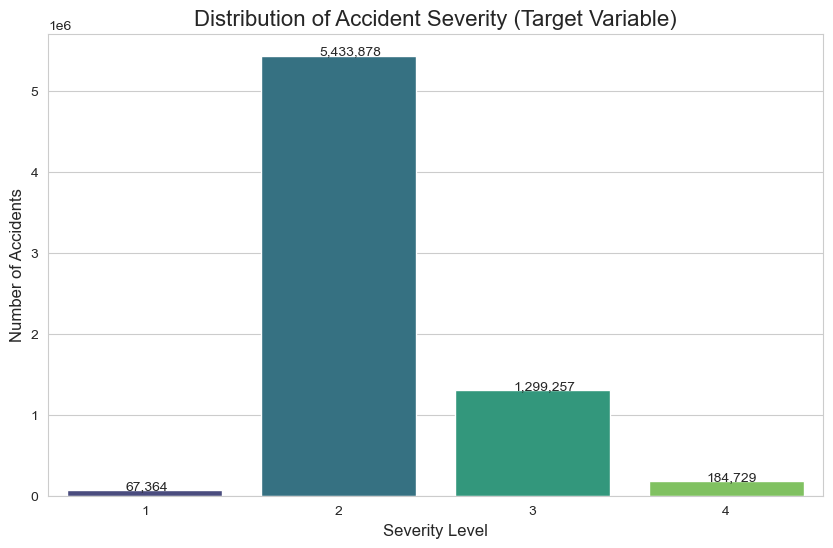

In [3]:
# CHART 1: Distribution of Accident Severity
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Severity', data=df, palette='viridis')

# Add counts on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + 0.3, p.get_height() + 10000))

plt.title("Distribution of Accident Severity (Target Variable)", fontsize=16)
plt.xlabel("Severity Level", fontsize=12)
plt.ylabel("Number of Accidents", fontsize=12)
plt.show()

C:\Users\fokunlola\AppData\Local\Temp\ipykernel_44952\1714422491.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Hour', data=df, palette='magma')


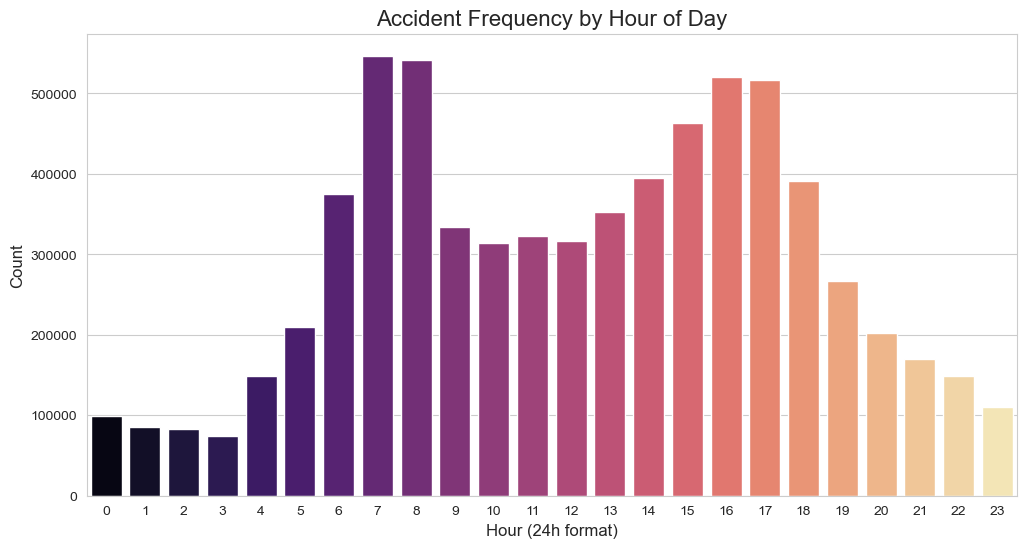

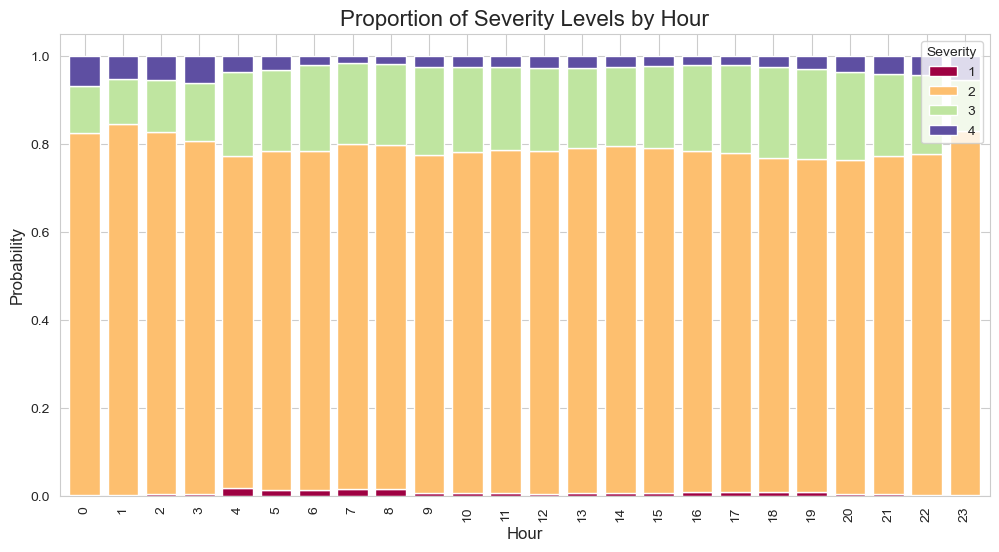

In [4]:
# CHART 2: Accidents by Hour of Day
plt.figure(figsize=(12, 6))
sns.countplot(x='Hour', data=df, palette='magma')
plt.title("Accident Frequency by Hour of Day", fontsize=16)
plt.xlabel("Hour (24h format)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

# CHART 3: Severity Proportion by Hour
# Normalized to show the probability of severity given the hour
ct_hour = pd.crosstab(df['Hour'], df['Severity'], normalize='index')
ct_hour.plot(kind='bar', stacked=True, colormap='Spectral', figsize=(12, 6), width=0.8)
plt.title("Proportion of Severity Levels by Hour", fontsize=16)
plt.xlabel("Hour", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.legend(title='Severity', loc='upper right')
plt.show()

C:\Users\fokunlola\AppData\Local\Temp\ipykernel_44952\4191856298.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states.index, y=top_states.values, palette='coolwarm')


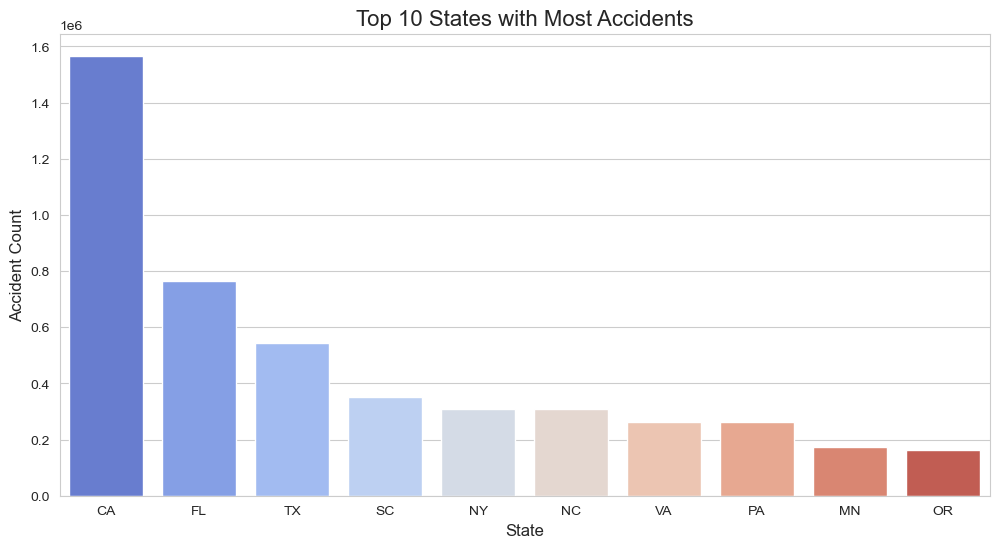

In [5]:
# CHART 4: Top 10 States by Accident Count
top_states = df['State'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_states.index, y=top_states.values, palette='coolwarm')
plt.title("Top 10 States with Most Accidents", fontsize=16)
plt.xlabel("State", fontsize=12)
plt.ylabel("Accident Count", fontsize=12)
plt.show()

C:\Users\fokunlola\AppData\Local\Temp\ipykernel_44952\3086285739.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_weather.index, x=top_weather.values, palette='Blues_r')


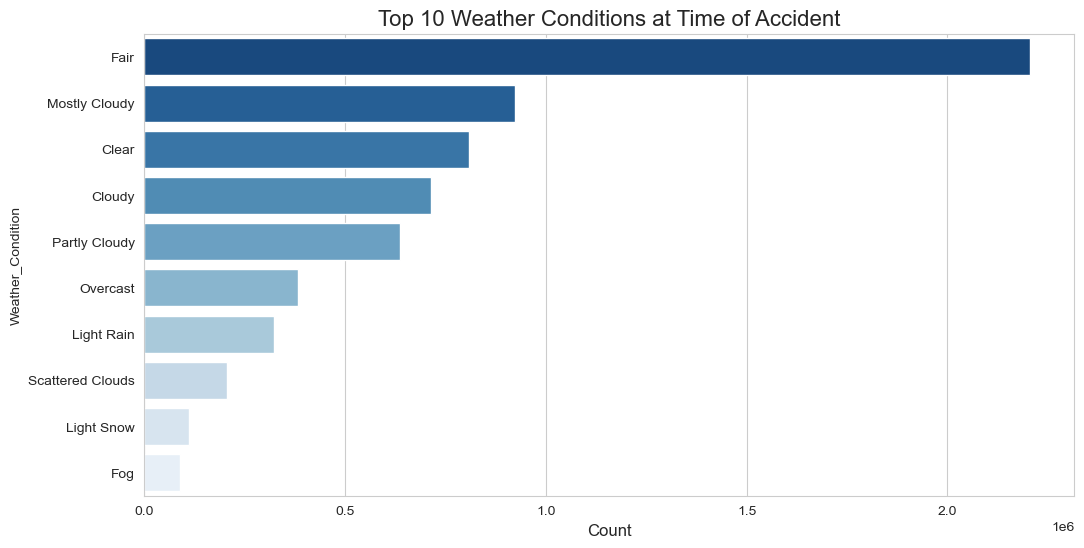

In [6]:
# CHART 5: Top 10 Weather Conditions
top_weather = df['Weather_Condition'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(y=top_weather.index, x=top_weather.values, palette='Blues_r')
plt.title("Top 10 Weather Conditions at Time of Accident", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.show()

>>> Loading full dataset...
Dataset Shape: (7728394, 46)

Data Types:
object            19
bool              13
float64           12
int64              1
datetime64[ns]     1
Name: count, dtype: int64


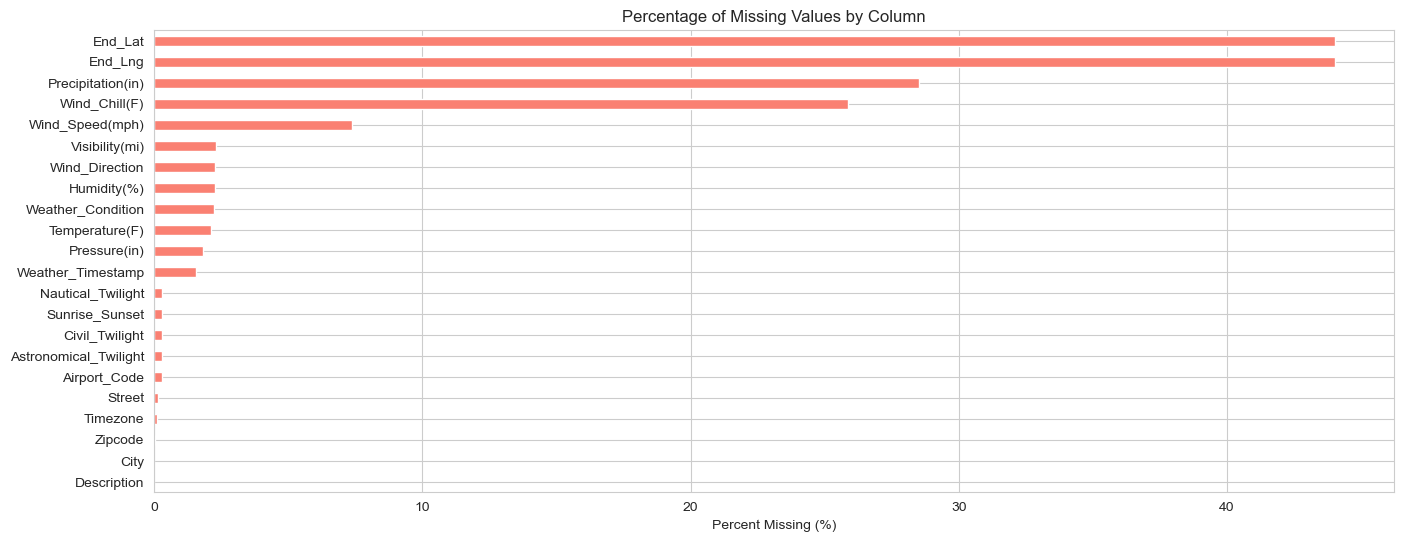

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization Settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# 1. LOAD DATASET (Fresh Load)
print(">>> Loading full dataset...")
# Load all columns to perform comprehensive EDA
df = pd.read_parquet("US_Accidents_March23.parquet")

# 2. DATA PROFILING
print(f"Dataset Shape: {df.shape}")
print("\nData Types:")
print(df.dtypes.value_counts())

# CHART: Missing Values Analysis
# Purpose: Decide which columns are unusable due to sparsity (e.g., End_Lat/Lng often missing)
plt.figure(figsize=(16, 6))
missing_percentage = df.isnull().mean() * 100
missing_percentage = missing_percentage[missing_percentage > 0].sort_values()
if not missing_percentage.empty:
    missing_percentage.plot(kind='barh', color='salmon')
    plt.title("Percentage of Missing Values by Column")
    plt.xlabel("Percent Missing (%)")
    plt.show()
else:
    print("No missing values found.")

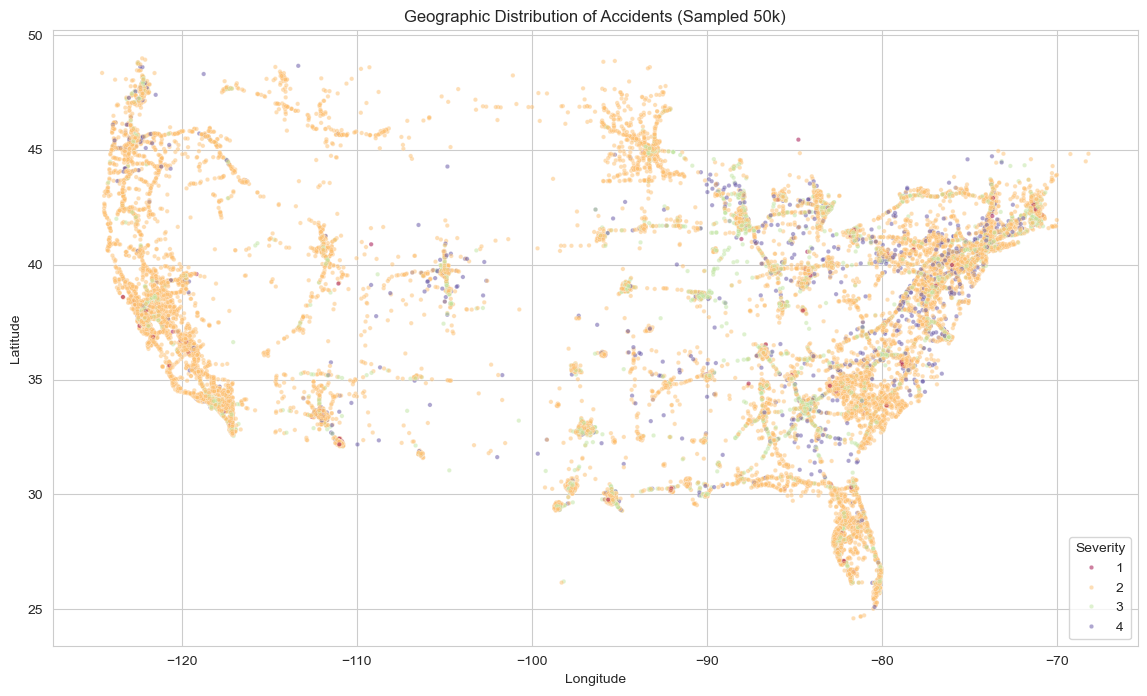

In [9]:
# CHART: Accident Density Map (Scatter)
# Purpose: Sanity check coordinates (Should look like a map of the USA)
plt.figure(figsize=(14, 8))
sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df.sample(50000, random_state=42), 
                hue='Severity', palette='Spectral', s=10, alpha=0.5, legend='full')
plt.title("Geographic Distribution of Accidents (Sampled 50k)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='lower right', title='Severity')
plt.show()

C:\Users\fokunlola\AppData\Local\Temp\ipykernel_44952\3044742461.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Severity', data=df, palette='viridis')


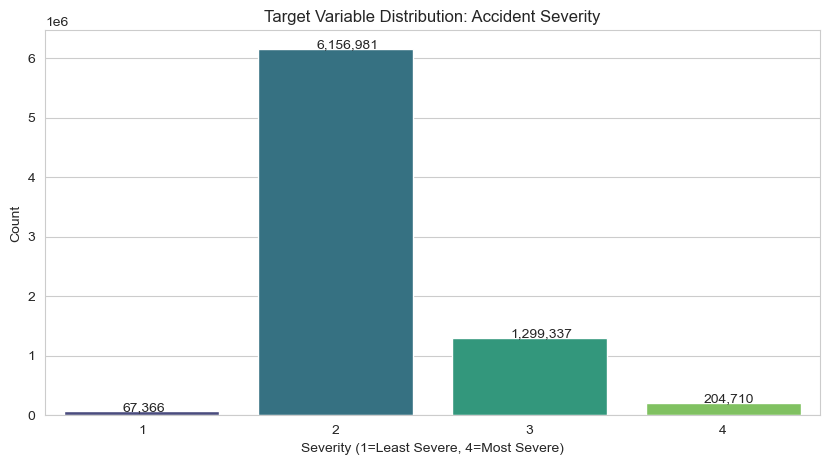

In [10]:
# CHART: Severity Distribution
# Purpose: Assess Class Imbalance (Severity 2 vs 4)
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Severity', data=df, palette='viridis')
plt.title("Target Variable Distribution: Accident Severity")
plt.ylabel("Count")
plt.xlabel("Severity (1=Least Severe, 4=Most Severe)")

# Add labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + 0.3, p.get_height() + 10000))
plt.show()

C:\Users\fokunlola\AppData\Local\Temp\ipykernel_44952\651128054.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_weather.index, x=top_weather.values, palette='Blues_r')


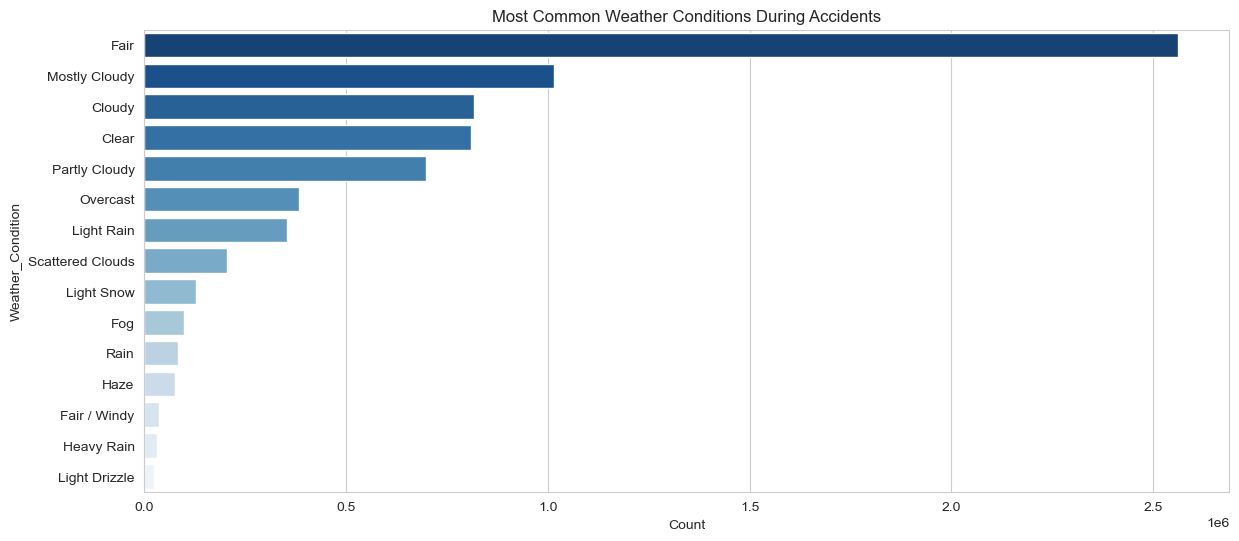

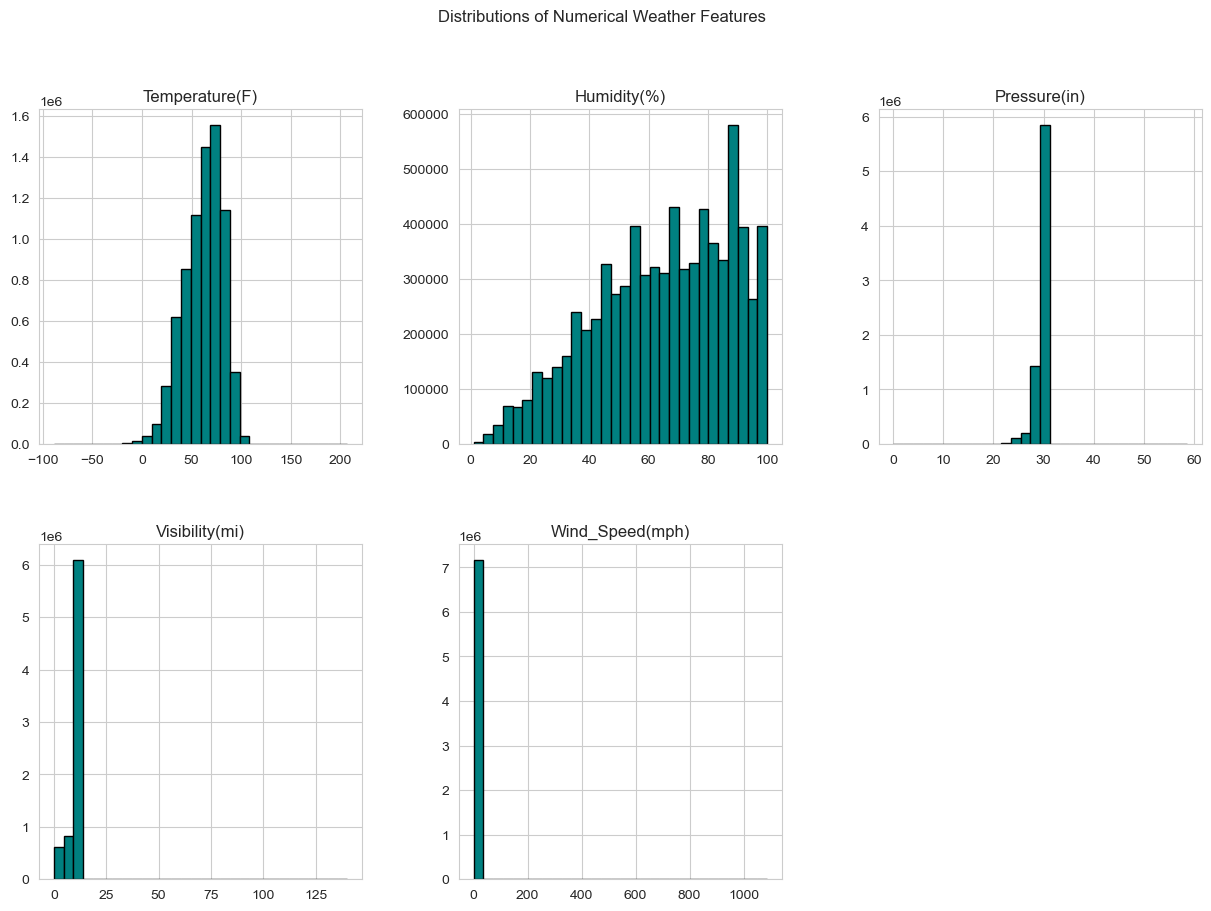

In [11]:
# CHART: Top 15 Weather Conditions
top_weather = df['Weather_Condition'].value_counts().head(15)
plt.figure(figsize=(14, 6))
sns.barplot(y=top_weather.index, x=top_weather.values, palette='Blues_r')
plt.title("Most Common Weather Conditions During Accidents")
plt.xlabel("Count")
plt.show()

# CHART: Numerical Weather Features Distributions
weather_cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']
df[weather_cols].hist(bins=30, figsize=(15, 10), layout=(2, 3), color='teal', edgecolor='black')
plt.suptitle("Distributions of Numerical Weather Features")
plt.show()
# Insight: Check for skewness. Visibility usually skewed left (mostly clear).

C:\Users\fokunlola\AppData\Local\Temp\ipykernel_44952\672803510.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bool_counts.values, y=bool_counts.index, palette='Reds_r')


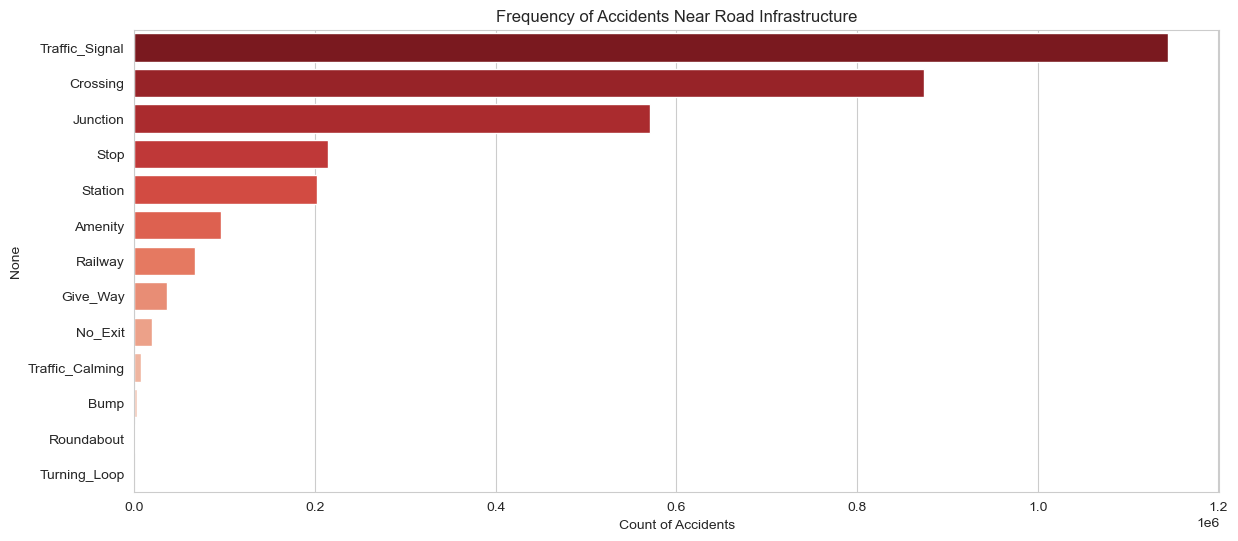

In [12]:
#Infrastructure Analysis (Boolean Flags)
# Select Boolean Columns
bool_cols = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 
             'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
             'Traffic_Signal', 'Turning_Loop']

# Calculate frequency of True values
bool_counts = df[bool_cols].sum().sort_values(ascending=False)

# CHART: Infrastructure Frequency
plt.figure(figsize=(14, 6))
sns.barplot(x=bool_counts.values, y=bool_counts.index, palette='Reds_r')
plt.title("Frequency of Accidents Near Road Infrastructure")
plt.xlabel("Count of Accidents")
plt.show()
# Insight: 'Traffic_Signal' and 'Junction' are usually the most common.

In [13]:
# Visualization Settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

In [2]:
# 2. BASIC CLEANING
# Convert Start_Time to datetime
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

# Drop rows with missing critical data (Time or Severity)
df = df.dropna(subset=['Start_Time', 'Severity'])

# Extract temporal features for EDA
df['Hour'] = df['Start_Time'].dt.hour
df['Month'] = df['Start_Time'].dt.month
df['Weekday'] = df['Start_Time'].dt.weekday

print(f">>> Data Loaded. Shape: {df.shape}")

>>> Data Loaded. Shape: (6985228, 49)


C:\Users\fokunlola\AppData\Local\Temp\ipykernel_44952\3377972923.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=severity_counts.index, y=severity_counts.values, palette='viridis')


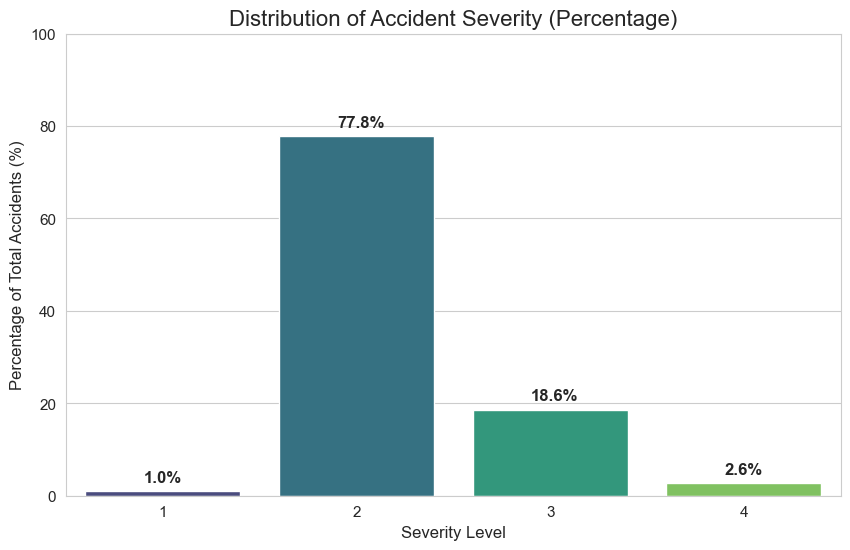

<Figure size 1200x600 with 0 Axes>

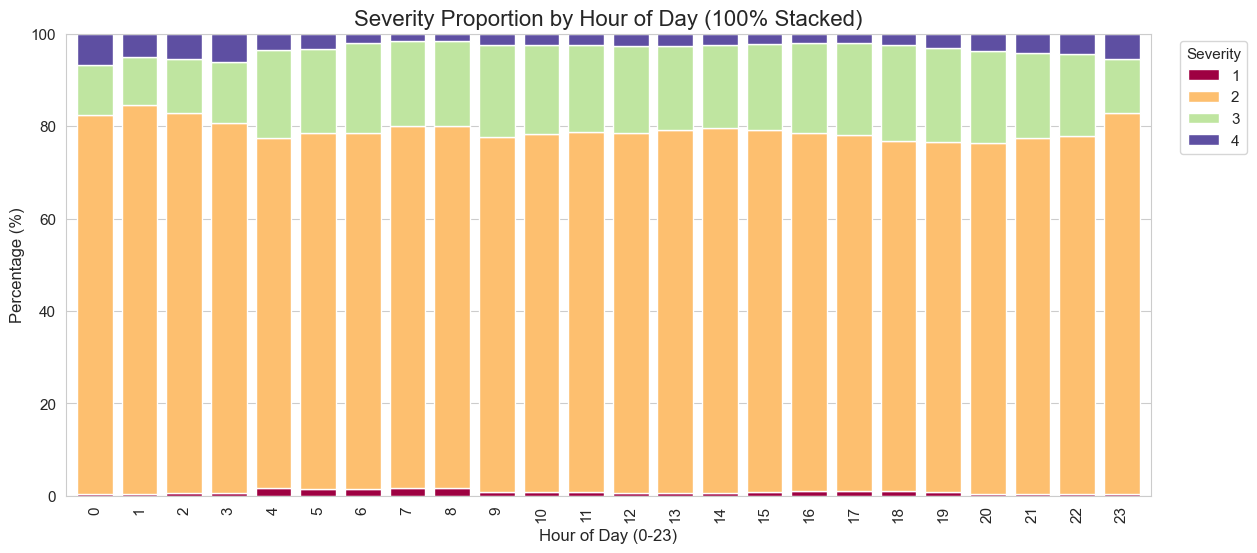

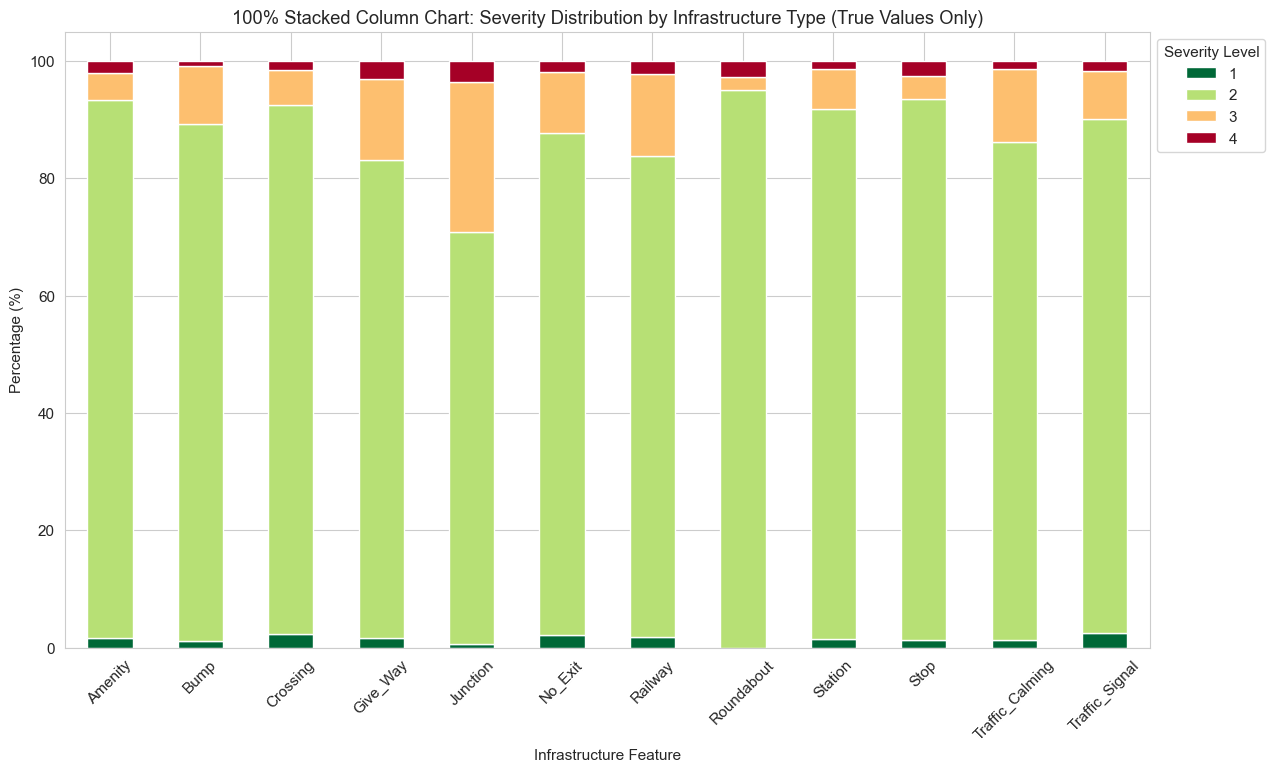

In [17]:
plt.figure(figsize=(10, 6))

# Calculate value counts and normalize to get percentages
severity_counts = df['Severity'].value_counts(normalize=True).sort_index() * 100

# Plot bar chart
ax = sns.barplot(x=severity_counts.index, y=severity_counts.values, palette='viridis')

plt.title("Distribution of Accident Severity (Percentage)", fontsize=16)
plt.ylabel("Percentage of Total Accidents (%)", fontsize=12)
plt.xlabel("Severity Level", fontsize=12)
plt.ylim(0, 100) # Fix y-axis to 100%

# Add percentage labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + 0.3, p.get_height() + 2), fontsize=12, fontweight='bold')

plt.show()
# Insight: This clearly shows the dominance of Severity 2 in percentage terms.

# -------------------------------------------------------
# CHART 2: Temporal Analysis (Percentage by Hour)
# -------------------------------------------------------
# We want to see: Of all accidents that happen at 8 AM, what % are Sev 1, 2, 3, 4?
plt.figure(figsize=(12, 6))

# Crosstab normalized by index (row) -> sums to 100% for each hour
ct_hour = pd.crosstab(df['Hour'], df['Severity'], normalize='index') * 100

# 100% Stacked Bar Plot
ct_hour.plot(kind='bar', stacked=True, colormap='Spectral', width=0.8, figsize=(14, 6))

plt.title("Severity Proportion by Hour of Day (100% Stacked)", fontsize=16)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xlabel("Hour of Day (0-23)", fontsize=12)
plt.legend(title='Severity', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.margins(0, 0)
plt.show()
# Insight: Look at how the 'Red' (Severity 4) bar grows relative to others during night hours.

# -------------------------------------------------------
# CHART 3: Boolean Infrastructure Flags (100% Column Chart)
# -------------------------------------------------------
# List of all boolean infrastructure columns
bool_cols = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 
    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal'
]

# Create a dataframe to store the distribution for each feature
severity_dist = []

for col in bool_cols:
    # Filter for rows where the feature is True
    temp_df = df[df[col] == True]
    
    if not temp_df.empty:
        # Calculate percentage distribution of severity for this specific feature
        dist = temp_df['Severity'].value_counts(normalize=True).sort_index() * 100
        dist.name = col
        severity_dist.append(dist)

# Combine into a single dataframe
logic_df = pd.concat(severity_dist, axis=1).T.fillna(0)

# Plotting the 100% Stacked Bar Chart
logic_df.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='RdYlGn_r')

plt.title('100% Stacked Column Chart: Severity Distribution by Infrastructure Type (True Values Only)')
plt.ylabel('Percentage (%)')
plt.xlabel('Infrastructure Feature')
plt.legend(title='Severity Level', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.show()

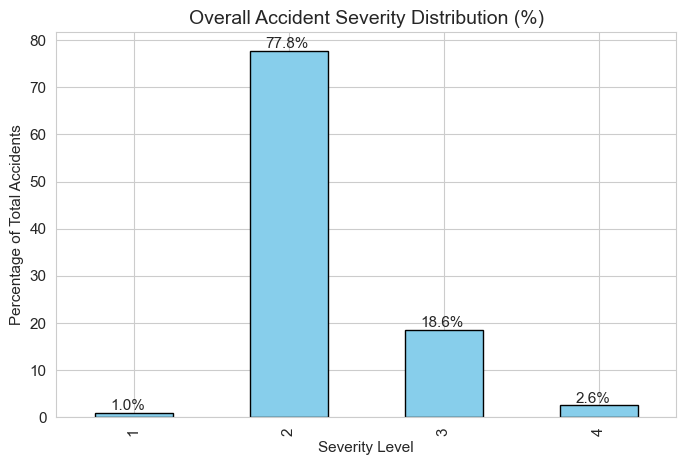

MemoryError: Unable to allocate 842. MiB for an array with shape (16, 6897635) and data type object

In [18]:
# 2. SEVERITY PERCENTAGE CHART
plt.figure(figsize=(8, 5))
sev_pct = df['Severity'].value_counts(normalize=True).sort_index() * 100
ax = sev_pct.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Overall Accident Severity Distribution (%)', fontsize=14)
plt.ylabel('Percentage of Total Accidents')
plt.xlabel('Severity Level')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + 0.1, p.get_height() + 0.5))
plt.show()

# 3. 100% STACKED CHART FOR ALL BOOLEAN VALUES (TRUE vs FALSE)
# Identify boolean columns (Infrastructure features)
bool_cols = [col for col in df.columns if df[col].dtype == 'bool']

# Prepare data for plotting
plot_data = []
for col in bool_cols:
    for val in [False, True]:
        subset = df[df[col] == val]
        if len(subset) > 0:
            counts = subset['Severity'].value_counts(normalize=True).sort_index() * 100
            for sev, pct in counts.items():
                plot_data.append({
                    'Feature': col,
                    'Status': 'True' if val else 'False',
                    'Severity': str(sev),
                    'Percentage': pct,
                    'Label': f"{col}\n({val})"
                })

plot_df = pd.DataFrame(plot_data)
pivot_df = plot_df.pivot_table(index='Label', columns='Severity', values='Percentage', fill_value=0)

# Plotting
plt.figure(figsize=(16, 8))
pivot_df.plot(kind='bar', stacked=True, colormap='viridis', figsize=(18, 7), width=0.8)
plt.title('Severity Distribution: True vs False for All Boolean Features (100% Stacked)', fontsize=15)
plt.ylabel('Percentage (%)')
plt.xlabel('Infrastructure Feature and its Boolean Status')
plt.legend(title='Severity', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# ----------------------------------------
# 1. Load Dataset
# ----------------------------------------


# ----------------------------------------
# 2. Define Target and Feature Groups
# ----------------------------------------
target = "Severity"

categorical_features = [
    "State", "City", "County",
    "Weather_Condition", "Wind_Direction"
]

boolean_features = [
    "Traffic_Signal", "Junction", "Crossing",
    "Stop", "Railway", "Amenity"
]

numerical_features = [
    "Temperature(F)", "Humidity(%)",
    "Visibility(mi)", "Pressure(in)",
    "Wind_Speed(mph)"
]

# ----------------------------------------
# 3. Target Encoding of Categorical Variables
# ----------------------------------------
# Compute global mean for smoothing
global_mean = df[target].mean()

for col in categorical_features:
    # Compute mean severity per category
    category_means = df.groupby(col)[target].mean()
    
    # Map category to mean severity
    df[col + "_TE"] = df[col].map(category_means)
    
    # Replace unseen or missing categories with global mean
    df[col + "_TE"].fillna(global_mean, inplace=True)

# ----------------------------------------
# 4. Numerical Conversion of Boolean Features
# ----------------------------------------
for col in boolean_features:
    df[col] = df[col].astype(int)

# ----------------------------------------
# 5. Assemble Fully Numerical Dataset
# ----------------------------------------
encoded_features = [col + "_TE" for col in categorical_features]

all_features = (
    numerical_features +
    encoded_features +
    boolean_features
)

X = df[all_features]

# ----------------------------------------
# 6. Normalization (Z-score Standardization)
# ----------------------------------------
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

# ----------------------------------------
# 7. Pearson Correlation Computation
# ----------------------------------------
# Include target for correlation with predictors
corr_df = pd.concat([X_scaled, df[target]], axis=1)

pearson_corr = corr_df.corr(method="pearson")

# ----------------------------------------
# 8. Extract Correlation with Severity
# ----------------------------------------
severity_corr = (
    pearson_corr[target]
    .drop(target)
    .sort_values(ascending=False)
)

print("Top Positive Correlations with Severity:")
print(severity_corr.head(10))

print("\nTop Negative Correlations with Severity:")
print(severity_corr.tail(10))

# ----------------------------------------
# 9. Save Correlation Matrix
# ----------------------------------------
pearson_corr.to_csv("pearson_correlation_matrix.csv")


C:\Users\fokunlola\AppData\Local\Temp\ipykernel_10528\3567207817.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col + "_TE"].fillna(global_mean, inplace=True)
C:\Users\fokunlola\AppData\Local\Temp\ipykernel_10528\3567207817.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

Top Positive Correlations with Severity:
City_TE                 0.343378
County_TE               0.299531
State_TE                0.202694
Weather_Condition_TE    0.174207
Wind_Direction_TE       0.148480
Junction                0.052478
Wind_Speed(mph)         0.044419
Pressure(in)            0.043948
Humidity(%)             0.019491
Visibility(mi)         -0.004034
Name: Severity, dtype: float64

Top Negative Correlations with Severity:
Wind_Speed(mph)    0.044419
Pressure(in)       0.043948
Humidity(%)        0.019491
Visibility(mi)    -0.004034
Railway           -0.011680
Temperature(F)    -0.019699
Amenity           -0.035218
Stop              -0.051376
Crossing          -0.117568
Traffic_Signal    -0.118994
Name: Severity, dtype: float64


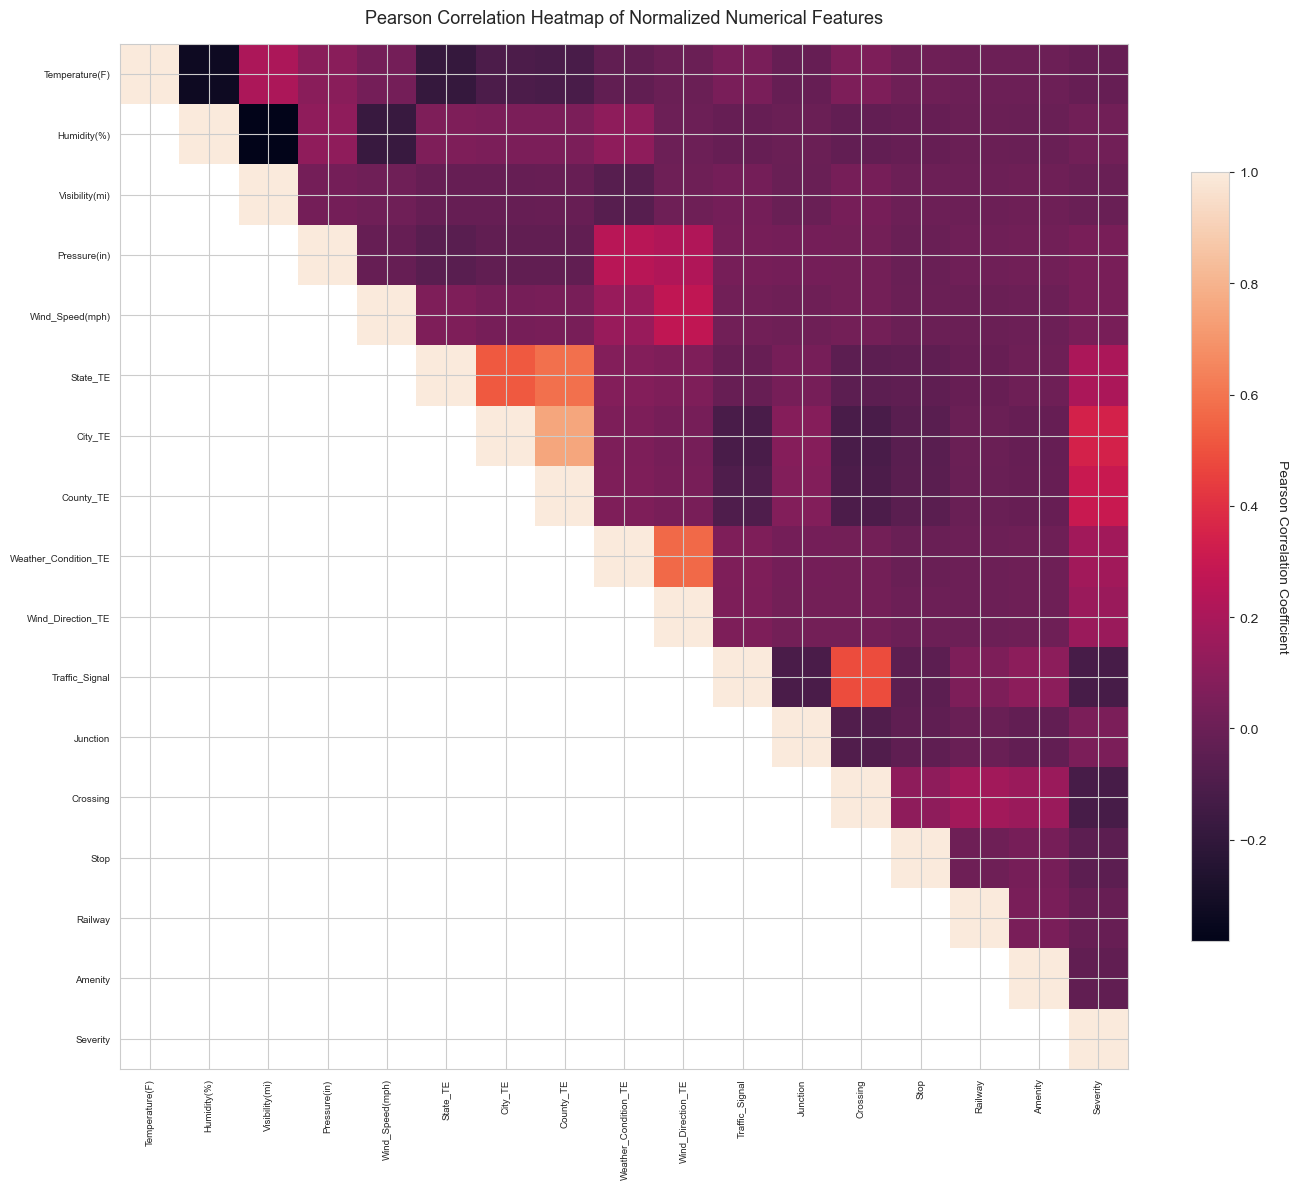

In [4]:


# =====================================================
# 2. Define Target and Feature Groups
# =====================================================
TARGET = "Severity"

categorical_features = [
    "State", "City", "County",
    "Weather_Condition", "Wind_Direction"
]

boolean_features = [
    "Traffic_Signal", "Junction", "Crossing",
    "Stop", "Railway", "Amenity"
]

numerical_features = [
    "Temperature(F)", "Humidity(%)",
    "Visibility(mi)", "Pressure(in)",
    "Wind_Speed(mph)"
]

# =====================================================
# 3. Target Encoding (Memory Safe)
# =====================================================
global_mean = df[TARGET].mean()

for col in categorical_features:
    means = df.groupby(col, observed=True)[TARGET].mean()
    df[col + "_TE"] = df[col].map(means).fillna(global_mean)

# Drop original categorical columns to free memory
df.drop(columns=categorical_features, inplace=True)

# =====================================================
# 4. Boolean → Numerical Conversion
# =====================================================
for col in boolean_features:
    df[col] = df[col].astype(np.int8)

# =====================================================
# 5. Assemble Fully Numerical Feature Matrix
# =====================================================
encoded_features = [c + "_TE" for c in categorical_features]

ALL_FEATURES = numerical_features + encoded_features + boolean_features

X = df[ALL_FEATURES].astype(np.float32)

# =====================================================
# 6. Normalization (Z-score, float32)
# =====================================================
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(
    X_scaled,
    columns=ALL_FEATURES,
    index=df.index,
    dtype=np.float32
)

# =====================================================
# 7. Pearson Correlation Grid (Memory Efficient)
# =====================================================
corr_data = pd.concat(
    [X_scaled, df[[TARGET]]],
    axis=1
)

pearson_corr = corr_data.corr(method="pearson")

# Save full grid
pearson_corr.to_csv(
    "full_pearson_correlation_grid.csv",
    float_format="%.5f"
)

# =====================================================
# 8. Memory-Optimized Heatmap (Upper Triangle)
# =====================================================
corr = pearson_corr.astype(np.float32)

mask = np.tril(np.ones(corr.shape), k=-1).astype(bool)
corr_masked = corr.mask(mask)

fig, ax = plt.subplots(figsize=(14, 12))

im = ax.imshow(
    corr_masked.values,
    aspect="auto",
    interpolation="nearest"
)

ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.index)))

ax.set_xticklabels(corr.columns, rotation=90, fontsize=7)
ax.set_yticklabels(corr.index, fontsize=7)

cbar = fig.colorbar(im, ax=ax, shrink=0.75)
cbar.set_label(
    "Pearson Correlation Coefficient",
    rotation=270,
    labelpad=15
)

ax.set_title(
    "Pearson Correlation Heatmap of Normalized Numerical Features",
    fontsize=13,
    pad=15
)

plt.tight_layout()

plt.savefig(
    "pearson_correlation_heatmap_optimized.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


In [9]:
# Load your accident dataset
df = pd.read_parquet("US_Accidents_March23.parquet")

# Ensure state column exists and is uppercase
df['State'] = df['State'].str.upper()

In [7]:
# ======================================
# 2. FEATURE ENGINEERING (FIXED)
# ======================================
print(">>> Engineering Features...")

# A. Datetime Fix
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

#  DROP ROWS WITH NO START TIME BEFORE CONVERSION ---
# This prevents the IntCastingNaNError
df = df.dropna(subset=['Start_Time']) 

df['Hour'] = df['Start_Time'].dt.hour.astype('int8')
df['Month'] = df['Start_Time'].dt.month.astype('int8')
df['Weekday'] = df['Start_Time'].dt.weekday.astype('int8')

# Now safe to calculate derived features
df['Is_Weekend'] = (df['Weekday'] >= 5).astype('int8')
df['Is_Rush_Hour'] = df['Hour'].isin([7, 8, 17, 18]).astype('int8')

# B. Text Analysis (Description) -> Then Drop
df['Description'] = df['Description'].fillna('').str.lower()
df['Highway_Key'] = df['Description'].str.contains('highway|i-|interstate|exits', regex=True).astype('int8')
df['Blocked_Key'] = df['Description'].str.contains('blocked|closed', regex=True).astype('int8')
df.drop(columns=['Start_Time', 'Description'], inplace=True)

# C. Weather
df['Weather_Condition'] = df['Weather_Condition'].fillna('')
df['Rain'] = df['Weather_Condition'].str.contains('Rain|Storm|Thunder', case=False).astype('int8')
df['Snow'] = df['Weather_Condition'].str.contains('Snow|Ice|Blizzard', case=False).astype('int8')

# Handle missing values in numeric columns before comparison
df['Visibility(mi)'] = df['Visibility(mi)'].fillna(df['Visibility(mi)'].median())
df['Wind_Speed(mph)'] = df['Wind_Speed(mph)'].fillna(df['Wind_Speed(mph)'].median())

df['Low_Vis'] = (df['Visibility(mi)'] < 1).astype('int8')
df['High_Wind'] = (df['Wind_Speed(mph)'] > 25).astype('int8')
df.drop(columns=['Weather_Condition'], inplace=True)

# D. Booleans to Int (Fill NaNs first just in case)
bool_cols = ['Traffic_Signal', 'Junction', 'Crossing', 'Stop']
for c in bool_cols:
    df[c] = df[c].fillna(False).astype('int8')

>>> Engineering Features...


KeyError: 'Start_Time'

In [7]:
state_features = pd.DataFrame({
    "Accident_Count": df.groupby("State").size(),
    "Avg_Distance": df.groupby("State")["Distance(mi)"].mean(),
    "Blocked_Rate": df.groupby("State")["Blocked_Key"].mean(),
    "Highway_Rate": df.groupby("State")["Highway_Key"].mean(),
    "Traffic_Signal_Rate": df.groupby("State")["Traffic_Signal"].mean(),
    "Avg_Pressure": df.groupby("State")["Pressure(in)"].mean(),
    "Avg_Wind_Speed": df.groupby("State")["Wind_Speed(mph)"].mean(),
    "Rush_Hour_Rate": df.groupby("State")["Is_Rush_Hour"].mean(),
    "Weekend_Rate": df.groupby("State")["Is_Weekend"].mean()
}).reset_index()


In [8]:
# Load US states geometry
us_states = gpd.read_file(
    "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip"
)

# Keep only contiguous + DC
us_states = us_states[~us_states["STUSPS"].isin(["AK", "HI", "PR"])]


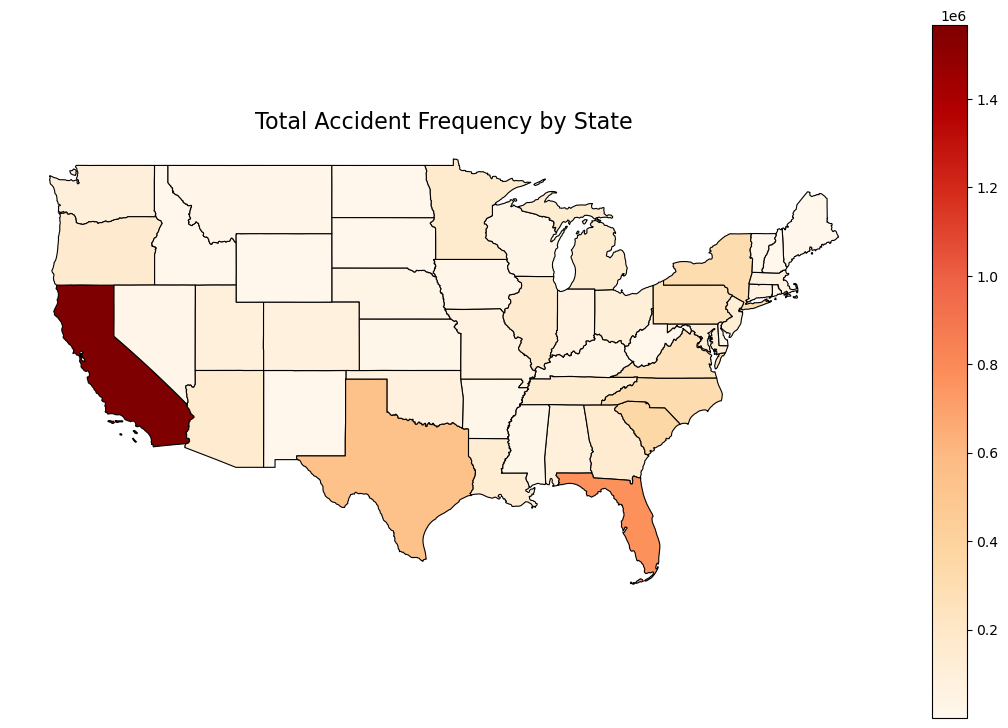

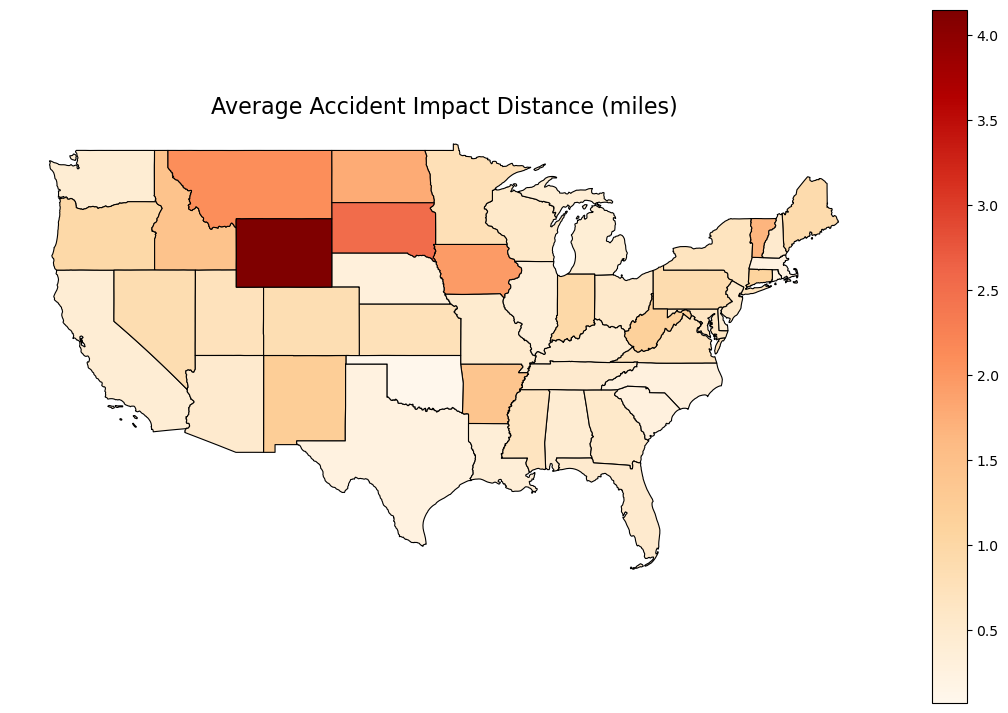

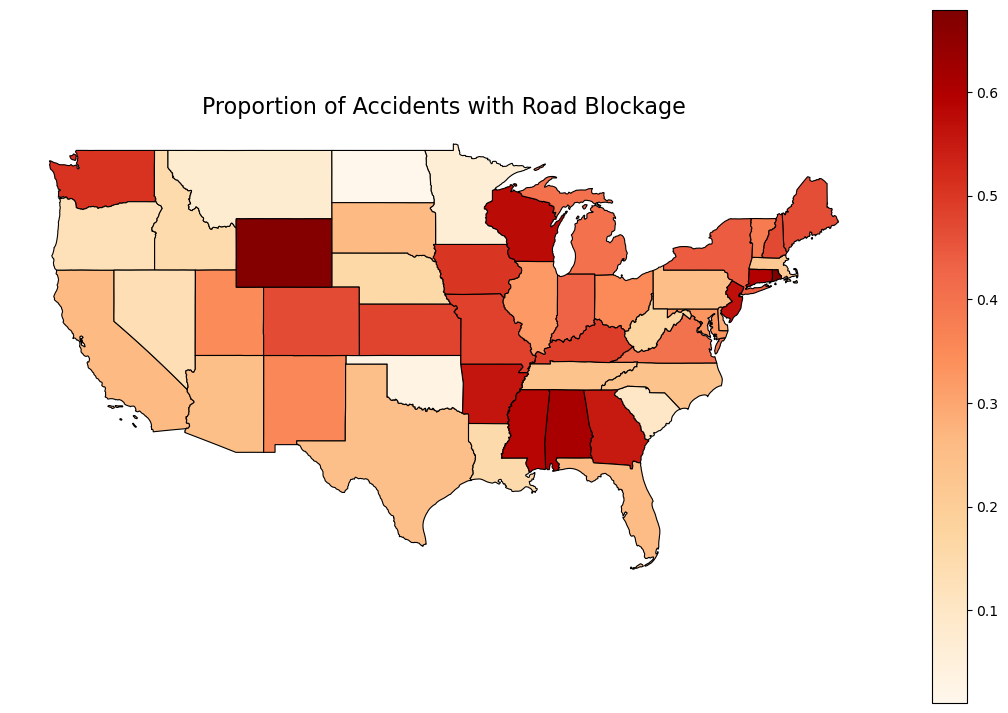

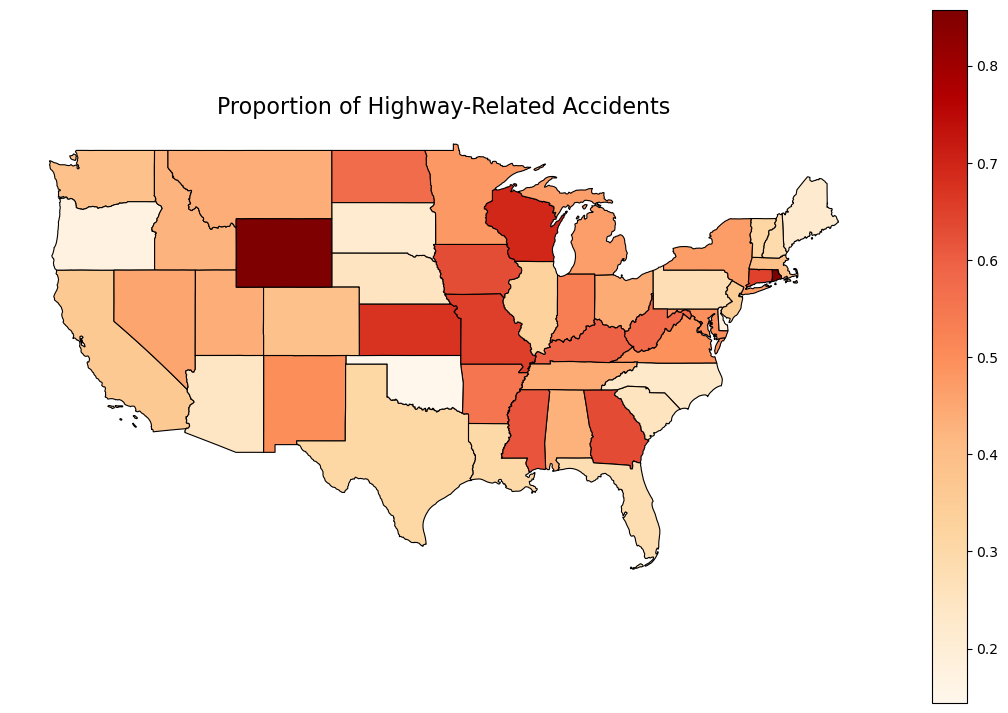

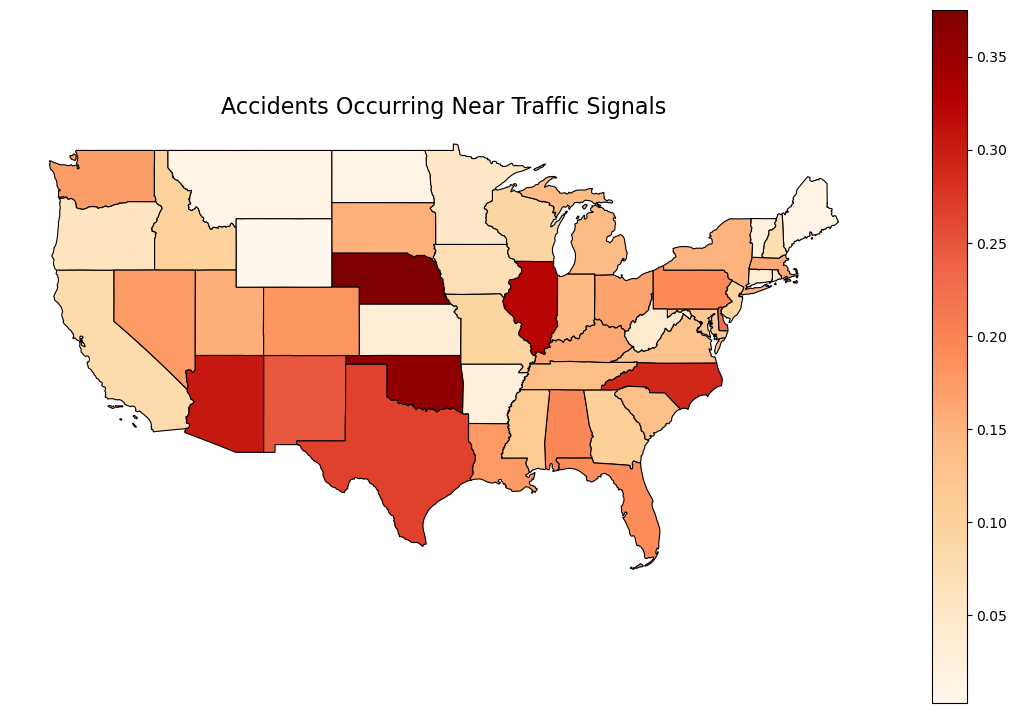

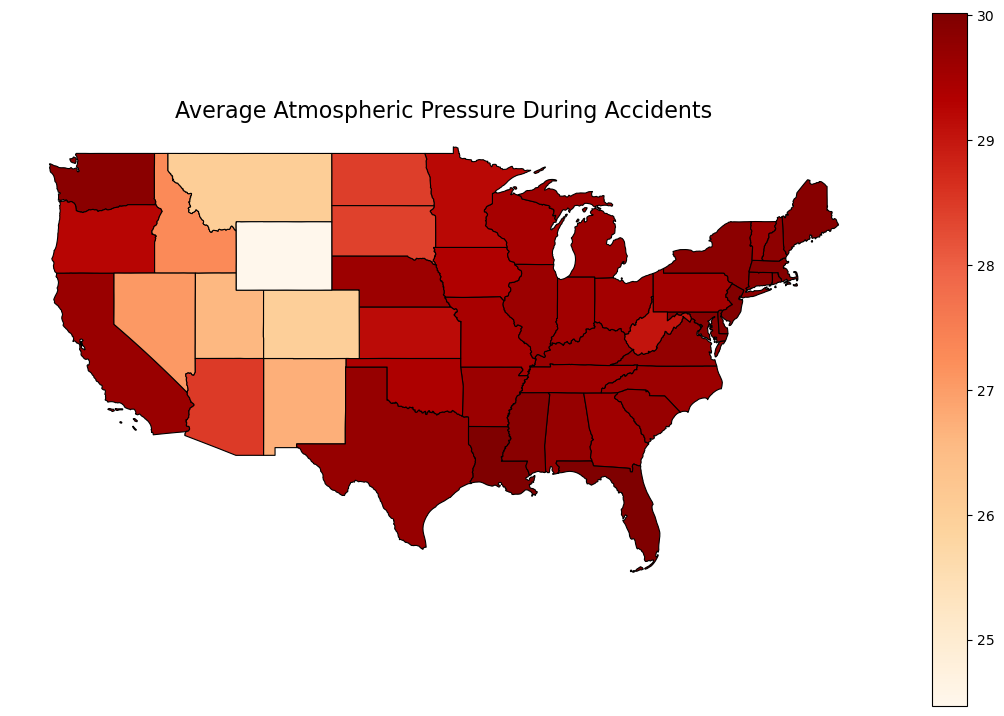

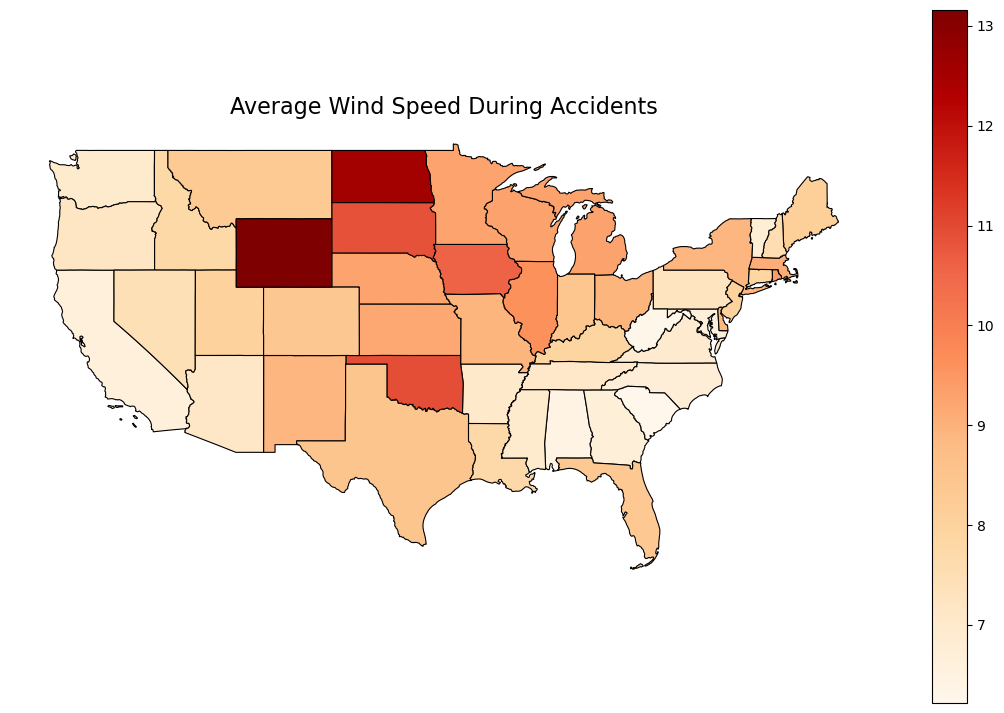

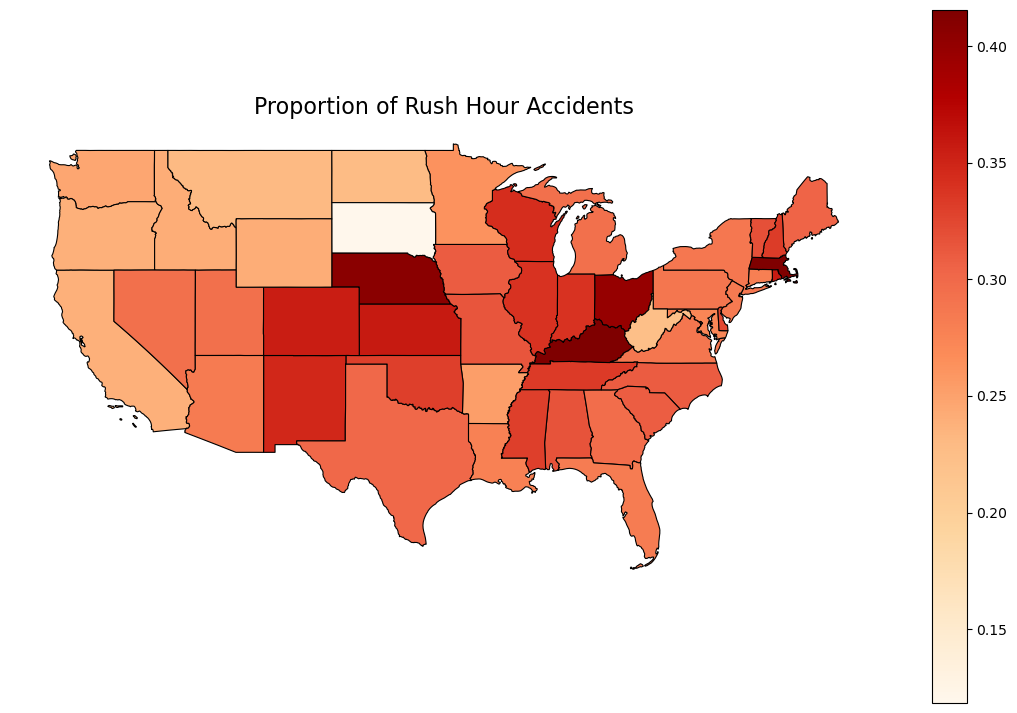

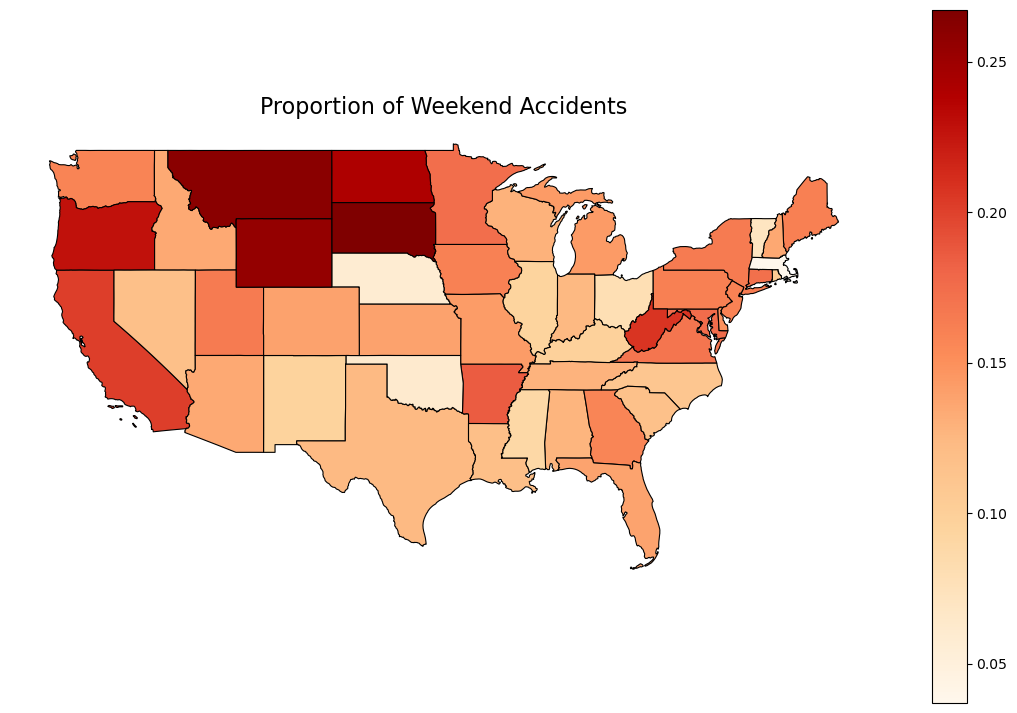

In [9]:
gdf = us_states.merge(
    state_features,
    left_on="STUSPS",
    right_on="State",
    how="left"
)

def plot_state_feature_map(gdf, feature, title, cmap="OrRd"):
    fig, ax = plt.subplots(1, 1, figsize=(14, 9))
    
    gdf.plot(
        column=feature,
        cmap=cmap,
        linewidth=0.8,
        edgecolor="black",
        legend=True,
        ax=ax,
        missing_kwds={"color": "lightgrey"}
    )
    
    ax.set_title(title, fontsize=16)
    ax.axis("off")
    plt.show()

features_to_plot = {
    "Accident_Count": "Total Accident Frequency by State",
    "Avg_Distance": "Average Accident Impact Distance (miles)",
    "Blocked_Rate": "Proportion of Accidents with Road Blockage",
    "Highway_Rate": "Proportion of Highway-Related Accidents",
    "Traffic_Signal_Rate": "Accidents Occurring Near Traffic Signals",
    "Avg_Pressure": "Average Atmospheric Pressure During Accidents",
    "Avg_Wind_Speed": "Average Wind Speed During Accidents",
    "Rush_Hour_Rate": "Proportion of Rush Hour Accidents",
    "Weekend_Rate": "Proportion of Weekend Accidents"
}

for feature, title in features_to_plot.items():
    plot_state_feature_map(gdf, feature, title)



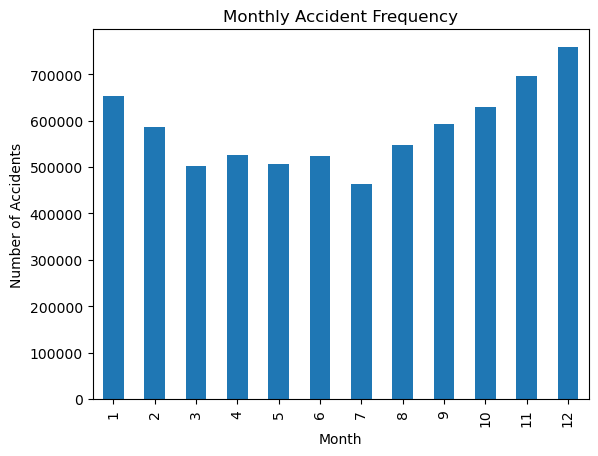

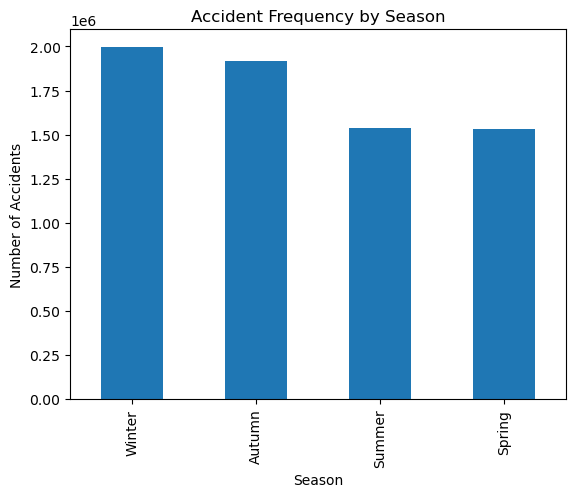

<Figure size 640x480 with 0 Axes>

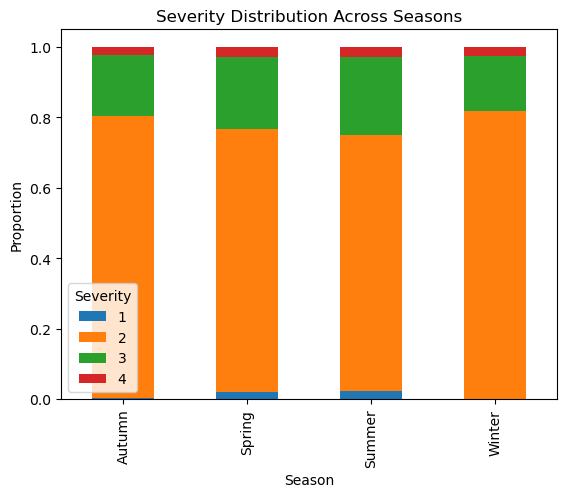

KeyError: 'Low_Vis'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 1. Create Temporal Features
# ===============================
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

#  DROP ROWS WITH NO START TIME BEFORE CONVERSION ---
# This prevents the IntCastingNaNError
df = df.dropna(subset=['Start_Time']) 


df['Month'] = df['Start_Time'].dt.month
df['Year'] = df['Start_Time'].dt.year
df['Season'] = df['Month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
})

# ===============================
# 2. Monthly Accident Frequency
# ===============================

monthly_counts = df.groupby('Month').size()

plt.figure()
monthly_counts.plot(kind='bar')
plt.title("Monthly Accident Frequency")
plt.xlabel("Month")
plt.ylabel("Number of Accidents")
plt.show()

# ===============================
# 3. Seasonal Accident Frequency
# ===============================

season_counts = df['Season'].value_counts()

plt.figure()
season_counts.plot(kind='bar')
plt.title("Accident Frequency by Season")
plt.xlabel("Season")
plt.ylabel("Number of Accidents")
plt.show()

# ===============================
# 4. Severity Distribution by Season
# ===============================

severity_season = pd.crosstab(df['Season'], df['Severity'], normalize='index')

plt.figure()
severity_season.plot(kind='bar', stacked=True)
plt.title("Severity Distribution Across Seasons")
plt.ylabel("Proportion")
plt.show()

# ===============================
# 5. Engineered Weather Feature Impact
# ===============================

weather_features = ['snow', 'Low_Vis', 'High_Wind']

for feature in weather_features:
    severity_weather = pd.crosstab(df[feature], df['Severity'], normalize='index')
    
    print(f"\nSeverity Distribution when {feature} occurs:")
    print(severity_weather)

# ===============================
# 6. Autumn Daylight Saving Proxy
# ===============================

df['Is_DST_Transition'] = df['Month'].isin([10, 11]).astype(int)

dst_analysis = pd.crosstab(df['Is_DST_Transition'], df['Severity'], normalize='index')

print("\nSeverity Distribution During DST Transition Months:")
print(dst_analysis)

# ===============================
# 7. Average Severity by Month
# ===============================

monthly_severity = df.groupby('Month')['Severity'].mean()

plt.figure()
monthly_severity.plot()
plt.title("Average Severity by Month")
plt.xlabel("Month")
plt.ylabel("Average Severity")
plt.show()


C:\Users\fokunlola\AppData\Local\Temp\ipykernel_6420\1330327636.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Start_Time'].dt.hour.astype('int8')
C:\Users\fokunlola\AppData\Local\Temp\ipykernel_6420\1330327636.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df['Start_Time'].dt.month.astype('int8')
C:\Users\fokunlola\AppData\Local\Temp\ipykernel_6420\1330327636.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi


Severity Distribution when Snow occurs:
Severity         1         2         3         4
Snow                                            
0         0.009822  0.778039  0.185954  0.026185
1         0.000869  0.771550  0.188312  0.039270

Severity Distribution when Low_Vis occurs:
Severity         1         2         3         4
Low_Vis                                         
0         0.009729  0.777541  0.186435  0.026295
1         0.004012  0.802278  0.157337  0.036373

Severity Distribution when High_Wind occurs:
Severity          1         2         3         4
High_Wind                                        
0          0.009664  0.777968  0.185978  0.026390
1          0.004718  0.764076  0.191481  0.039725


C:\Users\fokunlola\AppData\Local\Temp\ipykernel_6420\1330327636.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Is_DST_Transition'] = df['Month'].isin([10, 11]).astype(int)



Severity Distribution During DST Transition Months:
Severity                  1         2         3         4
Is_DST_Transition                                        
0                  0.011856  0.770838  0.190213  0.027094
1                  0.000203  0.808094  0.168024  0.023679


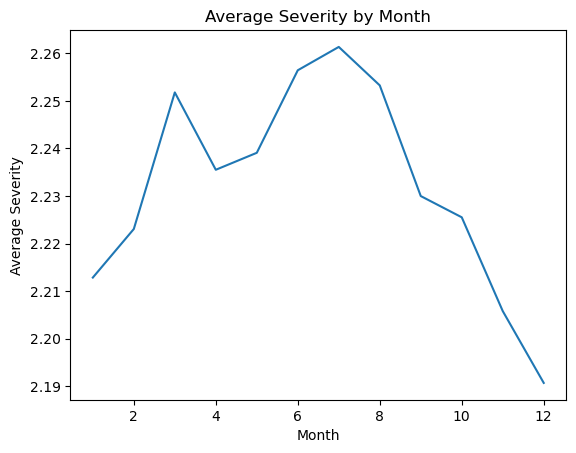

In [12]:
# ===============================
# 5. Engineered Weather Feature Impact
# ===============================

# C. Weather
df['Weather_Condition'] = df['Weather_Condition'].fillna('')
df['Rain'] = df['Weather_Condition'].str.contains('Rain|Storm|Thunder', case=False).astype('int8')
df['Snow'] = df['Weather_Condition'].str.contains('Snow|Ice|Blizzard', case=False).astype('int8')

# Handle missing values in numeric columns before comparison
df['Visibility(mi)'] = df['Visibility(mi)'].fillna(df['Visibility(mi)'].median())
df['Wind_Speed(mph)'] = df['Wind_Speed(mph)'].fillna(df['Wind_Speed(mph)'].median())

df['Low_Vis'] = (df['Visibility(mi)'] < 1).astype('int8')
df['High_Wind'] = (df['Wind_Speed(mph)'] > 25).astype('int8')

# A. Datetime Fix
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

#  DROP ROWS WITH NO START TIME BEFORE CONVERSION ---
# This prevents the IntCastingNaNError
df = df.dropna(subset=['Start_Time']) 

df['Hour'] = df['Start_Time'].dt.hour.astype('int8')
df['Month'] = df['Start_Time'].dt.month.astype('int8')
df['Weekday'] = df['Start_Time'].dt.weekday.astype('int8')

# Now safe to calculate derived features
df['Is_Weekend'] = (df['Weekday'] >= 5).astype('int8')
df['Is_Rush_Hour'] = df['Hour'].isin([7, 8, 17, 18]).astype('int8')


weather_features = ['Snow', 'Low_Vis', 'High_Wind']

for feature in weather_features:
    severity_weather = pd.crosstab(df[feature], df['Severity'], normalize='index')
    
    print(f"\nSeverity Distribution when {feature} occurs:")
    print(severity_weather)

# ===============================
# 6. Autumn Daylight Saving Proxy
# ===============================

df['Is_DST_Transition'] = df['Month'].isin([10, 11]).astype(int)

dst_analysis = pd.crosstab(df['Is_DST_Transition'], df['Severity'], normalize='index')

print("\nSeverity Distribution During DST Transition Months:")
print(dst_analysis)

# ===============================
# 7. Average Severity by Month
# ===============================

monthly_severity = df.groupby('Month')['Severity'].mean()

plt.figure()
monthly_severity.plot()
plt.title("Average Severity by Month")
plt.xlabel("Month")
plt.ylabel("Average Severity")
plt.show()